# Exploring FLIM Towards Semantic Segmentation

> This notebook covers the necessary steps to experiment with a FLIM and a U-Net architecture, visualizing its activations.

We will approach the following:

- Using FLIM to learn an encoder;
- Defining and using a U-Net model for semantic segmentation of parasites;
- Loading FLIM-Encoder as U-Net encoder;
- Modifying data loaders to work with LAB images (From our experiments, convolution filters learn better features in the LAB space);
- Visualizing U-Net activations;
- Using an adaptive decoder to predict parasite masks;
- Train a network with a frozen encoder (encoder weights were not trained); We will also verify FLIM as an encoder initialization method, training it together with the decoder. Finally, we will use a learning rate scheduler to train first epochs with a lower learning rate (to avoid messing with the learned FLIM weights with an untrained decoder).
- Compute metrics from our predicted segmentation masks.

## Auxiliary methods, classes, and variables

In [1]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
from tqdm import tqdm
from typing import List, Union
import json

from PIL import ImageOps
from tifffile import imsave
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch_snippets

from skimage.color import lab2rgb

In [2]:
data_path = Path("/home/john_doe/msc/2_datasets/parasites")
orig_path = data_path / Path("all_images")
labels_path = data_path / Path("all_truelabels")
arch_json = Path(
"/home/john_doe/msc/3_repos/msc_repo/experiments/2_flim_activations/new_flim/single_reshaped_image/arch2d_seg.json"
)
weights_path = Path(
"/home/john_doe/msc/3_repos/msc_repo/experiments/2_flim_activations/new_flim/single_reshaped_image/model"
)

In [3]:
""" From our experiments, we saw that convolutional operations
were able to extract better features on LAB Space. So we need to 
enable conversion to LAB.
"""
def _labf(x):
    if x >= 8.85645167903563082e-3:
        return x ** (0.333333333333333)
    else:
        return (841.0 / 108.0) * (x) + (4.0 / 29.0)
    
def rgb2lab(image, norm_value):
    image = np.array(image)
    image = image / norm_value
    
    labf_v = np.vectorize(_labf)
    
    new_image = np.zeros_like(image)
    
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    X = (
        0.4123955889674142161 * R
        + 0.3575834307637148171 * G
        + 0.1804926473817015735 * B
    )
    Y = (
        0.2125862307855955516 * R
        + 0.7151703037034108499 * G
        + 0.07220049864333622685 * B
    )
    Z = (
        0.01929721549174694484 * R
        + 0.1191838645808485318 * G
        + 0.9504971251315797660 * B
    )
    
    X = labf_v(X / 0.950456)
    Y = labf_v(Y / 1.0)
    Z = labf_v(Z / 1.088754)
    
    new_image[:, :, 0] = 116 * Y - 16
    new_image[:, :, 1] = 500 * (X - Y)
    new_image[:, :, 2] = 200 * (Y - Z)
    
    new_image[:, :, 0] = new_image[:, :, 0] / 99.998337
    new_image[:, :, 1] = (new_image[:, :, 1] + 86.182236) / (86.182236 + 98.258614)
    new_image[:, :, 2] = (new_image[:, :, 2] + 107.867744) / (107.867744 + 94.481682)
    
    return new_image.astype(np.float32)

In [4]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        """If training with the whole dataset we must resize images
        to the same size (240, 240)"""
        # Converts to tensor and normalize [0, 255] -> [0, 1]
        self.image_transforms = transforms.ToTensor()
        self.label_transforms = transforms.ToTensor()

    def __len__(self):
        # If image id not provided, we are training with the whole dataset
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]

        image = rgb2lab(Image.open(image_path), norm_value=255)
        image = self.image_transforms(image)
        
        label = ImageOps.grayscale(Image.open(label_path))
        label = self.label_transforms(label)
        
        # Tackles label as a two channel prediction (Background and Foreground)
        background = torch.zeros(1, label.shape[1], label.shape[2])
        foreground = torch.zeros(1, label.shape[1], label.shape[2])
        background[label == 0] = 1
        foreground[label == 1] = 1
        label = torch.cat([background, foreground], axis=0)

        return image, label

In [5]:
# Method to visualize Dataset Item (LAB)
def visualize_dataset_item(dataset, item):
    img, label = dataset.__getitem__(item)
    img = img.permute(1, 2, 0)
    img[:,:, 0] = img[:,:, 0] * 99.998337
    img[:,:, 1] = img[:,:, 1] * (86.182236 + 98.258614) - 86.182236
    img[:,:, 2] = img[:,:, 2] * (107.867744 + 94.481682) - 107.867744
    img = lab2rgb(img)

    plt.subplot(131)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(img)
    plt.subplot(132)
    plt.yticks([]),plt.xticks([])
    plt.title("Background")
    plt.imshow(label[0], cmap="gray")
    plt.subplot(133)
    plt.yticks([]),plt.xticks([])
    plt.title("Foreground")
    plt.imshow(label[1], cmap="gray")

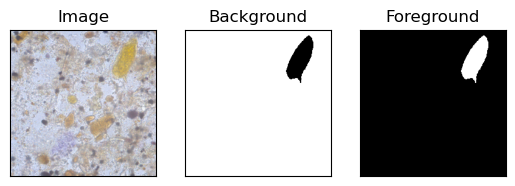

In [6]:
# Let us first verify an image (LAB) with its labels
images = os.listdir(orig_path)
images.sort()
labels = images
n_train = int((0.8 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]

# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

seg_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
sample_dataloader = DataLoader(seg_dataset, batch_size=1, shuffle=False)
train_images_sample, train_labels_sample = next(iter(sample_dataloader))

visualize_dataset_item(seg_dataset, 0)

Again, we define our code to build U-Net model and save its activations!

In [7]:
# Utilitarians blocks for UNet Decoder
# Upsamples input feature map
def up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )
    
# Defines convolutional blocks for our decoder
def conv(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    
# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        self.activations_path = activations_path
        
        # Encoder Convolutional Blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=n_kernels[0],
                kernel_size=kernel_sizes[0],
                padding=kernel_sizes[0] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=kernel_sizes[0], stride=2,
                padding=kernel_sizes[0] // 2
            )
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[0], out_channels=n_kernels[1],
                kernel_size=kernel_sizes[1],
                padding=kernel_sizes[1] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=kernel_sizes[1], stride=2,
                padding=kernel_sizes[1] // 2
            )
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[1], out_channels=n_kernels[2],
                kernel_size=kernel_sizes[2],
                padding=kernel_sizes[2] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=kernel_sizes[2], stride=2,
                padding=kernel_sizes[2] // 2
            )
        )
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[2], out_channels=2*n_kernels[2],
            kernel_size=bottleneck_size, stride=2, padding=bottleneck_size//2
        )
        
        # Decoder
        self.up_conv1 = up_conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2]
        )
        self.dec_conv1 = conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2
        )
        self.up_conv2 = up_conv(
            in_channels=n_kernels[2], out_channels=n_kernels[1]
        )
        self.dec_conv2 = conv(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv3 = up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv3 = conv(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.up_conv_pred = up_conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0]
        )
        self.dec_conv4 = conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=2, kernel_size=1
        )
        
        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.block3.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.dec_conv3.apply(init_weights)
        self.up_conv_pred.apply(init_weights)
        # Final conv before prediction
        self.dec_conv4.apply(init_weights)
        self.pred.apply(init_weights)    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}
              
        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(x1)
        self.activations["encoder"].append(x2)
        x3 = self.block3(x2)
        self.activations["encoder"].append(x3)
        
        # Bottleneck
        bottleneck = self.bottleneck(x3)
        
        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv3(x)
        self.activations["decoder"].append(x)
        x = self.up_conv_pred(x)
        x = self.dec_conv4(x)
        x = self.pred(x)
        
        return x
    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)
    
    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = data_loader.dataset.image_transforms(
                rgb2lab(Image.open(image_path), norm_value=255)
            )
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to("cuda")
            self.to("cuda")
            self.forward(image_data)
        
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )
                    
            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_loss'], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_accuracy'], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

Additionally, as we will use a FLIM Encoder as our U-Net encoder, we define methods to load FLIM Encoder's weight into the U-Net encoder.

In [8]:
def get_bias(bias_path: PosixPath) -> np.ndarray:
    with open(bias_path, "r") as file:
        n_kernels = file.readline()
        bias = file.readline().strip().split(" ")
    
    bias = np.array(bias).astype(np.float32)
    
    return bias

def shift_weights(weights: np.ndarray, kernel_size: int, in_channels: int) -> np.ndarray:
    kn = 1 # neutral element
    
    # Iterates over each kernel size
    for i in range(len(kernel_size)):
        kn = kn * kernel_size[i]
    
    mid_index = int(kn / 2) + 1
    
    weights = np.concatenate(
        (
            weights[in_channels: mid_index * in_channels],
            weights[0:in_channels],
            weights[mid_index * in_channels:]
        ),
        axis=0
    )
    
    return weights

def get_weights(kernel_path: PosixPath,  kernel_size: int, in_channels: int) -> np.ndarray:
    weights = np.load(kernel_path)
    weights = shift_weights(weights, kernel_size, in_channels)
    
    return weights

def load_FLIM_encoder(model: UNet, arch_json: PosixPath, weights_path: PosixPath, channels: List[int]) -> None:
    with open(arch_json, "r") as json_data:
        arch_description = json.load(json_data)
    
    n_layers = arch_description["nlayers"]
    
    in_channels = channels[0]
    print("[INFO] Loading FLIM Encoder")
    model.block1[0].weight.data
    model.block1[0].bias.data
    for n in range(1, n_layers + 1):
        out_channels = channels[n]

        print(f"[INFO] Loading Layer {n} weights")
        # Gets each encoder Block to set its weights and biases
        model_block = getattr(model, f"block{n}")
        
        # Sets its biases
        bias_path = weights_path / Path(f"000001-conv{n}-bias.txt")
        kernel_path = weights_path / Path(f"000001-conv{n}-kernels.npy")
        # Get biases and set to model - Accessing conv block biases
        bias = get_bias(bias_path)
        bias = nn.Parameter(torch.from_numpy(bias).float())
        model_block[0].bias.data = bias
        
        # Get kernel weights and set to model - Accessing conv block weights
        kernel_size = arch_description[f"layer{n}"]["conv"]["kernel_size"]
        weights = get_weights(kernel_path, kernel_size, in_channels)
        weights = weights.transpose()
        weights = weights.reshape(out_channels, kernel_size[1], kernel_size[0], in_channels).transpose(0, 3, 1, 2)
        weights = nn.Parameter(torch.from_numpy(weights).float())
        model_block[0].weight.data = weights
        
        in_channels = channels[n]

Then, let us load a sample weight and save our activations, to validate it against FLIM activations. They must match.

In [9]:
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/test_clean_code")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights


In [10]:
data, label = next(iter(sample_dataloader))
data = data.to("cuda")
unet.to("cuda")
unet(data)
unet.save_activations(0, sample_dataloader)

[INFO] Saving activations!


100%|██████████| 76/76 [00:11<00:00,  6.36it/s]


## Utilitarians fuction to run train and inferences

This section implements our training loop. Also, it enables the use of a learning rate scheduler, and training with an frozen encoder.

Let us first implement our learning rate scheduler, and visualize it.

In [11]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

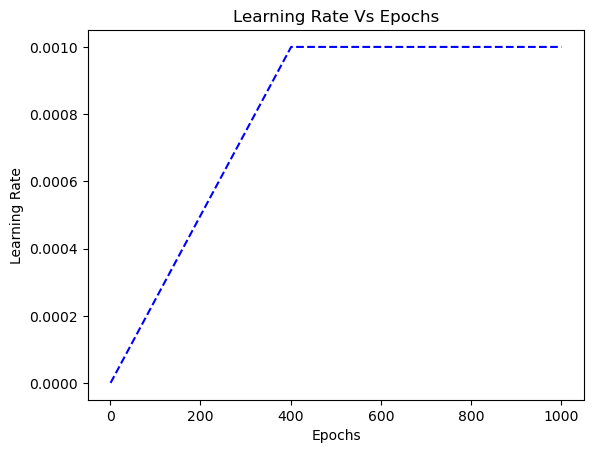

In [12]:
# create a simple model 
model = nn.Sequential(
    nn.Linear(34, 34),
    nn.ReLU(),
    nn.Linear(34, 1),
    nn.Sigmoid()
)

lr=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
# Start Factor of the optimizer learning rate
# End factor of the optimizer learning rate
# Total iterations to increase from Start to End Factor
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-3, end_factor=1, total_iters=400, verbose=False)

lrs = []
epochs = []

for epoch in range(1000):
    lr = scheduler.get_last_lr()
    epochs.append(epoch+1)
    lrs.append(lr)
    optimizer.step()
    scheduler.step()
    
plt.plot(epochs, lrs, "b--")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Vs Epochs")
plt.show()

Now, we define our training loop, with the followings capability:

- Freeze the Encoder's Weights
- Train with Learning Rate Scheduler

In [13]:
from torch_snippets import optim, Report
from torchsummary import summary
import monai
from monai.losses import DiceLoss, DiceFocalLoss
import cv2

In [14]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(sigmoid=False, batch=False),
    "dice_focal": DiceFocalLoss()
}

class Loss(nn.Module):
    def __init__(
            self,
            loss_fn: Union[torch.nn.modules.loss, monai.losses],
            weights: List[float] = [1.0, 1.0]
        ):
        super().__init__()
        self.loss_fn = loss_fn
        self.background_weight = weights[0]
        self.foreground_weight = weights[1]

    def forward(self, y_pred, y_true):
        background_loss = self.loss_fn(y_pred[:,0, ...], y_true[:, 0, ...])
        foreground_loss = self.loss_fn(y_pred[:,1, ...], y_true[:, 1, ...])
        background_loss *= self.background_weight
        foreground_loss *= self.foreground_weight
        loss = background_loss + foreground_loss
        return loss

In [15]:
# Finaly, we define and test our training loop
# Save activations every N epochs
N_SAVE_ACTIVATIONS = 200
def train_loop(epochs, model, dataloader, lr, loss_function, weights, freeze_encoder=False, use_lr_scheduler=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-3, end_factor=1, total_iters=400, verbose=False)
    model.to("cuda")
    
    # Freeze encoder weights
    if freeze_encoder:
        model.block1.requires_grad_(False)
        model.block1.trainable = False
        model.block2.requires_grad_(False)
        model.block2.trainable = False
        model.block3.requires_grad_(False)
        model.block3.trainable = False
    
    logger = Report(epochs)
    loss = Loss(loss_function, weights)

    for epoch in range(epochs):
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to("cuda")
            ground_truth = ground_truth.to("cuda")
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = nn.functional.sigmoid(prediction)
            loss_value = loss(prediction, ground_truth)

            accuracy = (
                (prediction[:,1,...] > prediction[:,0,...]) == ground_truth[:,1,...]
            ).float().mean()

            loss_value.backward()
            optimizer.step()
        
        # At the end of the epoch, we tach a step in our LR Scheduler
        if use_lr_scheduler:
            scheduler.step()
        
        
        logger.record(
            epoch + 1,
            trn_loss=loss_value.item(),
            trn_accuracy=accuracy.item()
            )
        if ((epoch + 1) % N_SAVE_ACTIVATIONS) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

In [16]:
# We also define a method for prediction and evaluation
# This code gets the trained model and execute inferences on the Dataloader
from medpy.metric import binary
np.bool = np.bool_

@torch.no_grad()
def predict_and_evaluate(
        model: UNet, 
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.activations_path / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)
    
    accuracies = []
    dices = []

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image_data = data_loader.dataset.image_transforms(
                rgb2lab(Image.open(image_path), norm_value=255)
            )
        ground_truth = data_loader.dataset.label_transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to("cuda")
        prediction = model(image_data)
        prediction = nn.functional.sigmoid(prediction)
        
        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((240, 240), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy()
        mask[(prediction[0,1,...] > prediction[0,0,...])] = 1
        
        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        dice = binary.dc(mask, ground_truth)
        dices.append(dice)
        
        cv2.imwrite(
            str(path_to_save), mask * 255
        )
    
    accuracies = np.array(accuracies)
    dices = np.array(dices)
    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")

## Now, we define the following experiments:

- Load weights and train the model with a single image and test on the whole test data
    - Froozen encoder
    - LR Fixed
    - LR Scheduler
- Load weights and train the model on the whole train data and test on the whole test data
    - Froozen encoder
    - LR Fixed
    - LR Scheduler
- Load weights and train model on reduced train data and test on the whole dataset
    - Froozen encoder
    - LR Fixed
    - LR Scheduler

### Load weights and train the model with a single image and test on the whole test data

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.233  trn_accuracy: 0.811  (0.12s - 121.73s remaining)
EPOCH: 2.000  trn_loss: 1.215  trn_accuracy: 0.822  (0.18s - 88.42s remaining)
EPOCH: 3.000  trn_loss: 1.199  trn_accuracy: 0.831  (0.23s - 76.13s remaining)
EPOCH: 4.000  trn_loss: 1.184  trn_accuracy: 0.837  (0.28s - 69.23s remaining)
EPOCH: 5.000  trn_loss: 1.170  trn_accuracy: 0.842  (0.32s - 64.08s remaining)
EPOCH: 6.000  trn_loss: 1.157  trn_accuracy: 0.847  (0.36s - 60.47s remaining)
EPOCH: 7.000  trn_loss: 1.145  trn_accuracy: 0.853  (0.41s - 57.91s remaining)
EPOCH: 8.000  trn_loss: 1.133  trn_accuracy: 0.859  (0.45s - 56.17s remaining)
EPOCH: 9.000  trn_loss: 1.121  trn_accuracy: 0.864  (0.50s - 54.67s remaining)
EPOCH: 10.000  trn_loss: 1.110  trn_accuracy: 0.872  (0.54s - 53.42s remaining)
EPOCH: 11.000  trn_loss: 1.100  trn_accuracy: 0.879  (0.59s - 52.65s remaining)
EPOCH: 

100%|██████████| 76/76 [00:11<00:00,  6.58it/s]


EPOCH: 201.000  trn_loss: 0.318  trn_accuracy: 0.999  (20.12s - 79.96s remaining)
EPOCH: 202.000  trn_loss: 0.317  trn_accuracy: 0.999  (20.17s - 79.67s remaining)
EPOCH: 203.000  trn_loss: 0.315  trn_accuracy: 0.999  (20.21s - 79.36s remaining)
EPOCH: 204.000  trn_loss: 0.313  trn_accuracy: 0.999  (20.26s - 79.05s remaining)
EPOCH: 205.000  trn_loss: 0.311  trn_accuracy: 0.999  (20.30s - 78.74s remaining)
EPOCH: 206.000  trn_loss: 0.310  trn_accuracy: 0.999  (20.35s - 78.45s remaining)
EPOCH: 207.000  trn_loss: 0.308  trn_accuracy: 0.999  (20.40s - 78.16s remaining)
EPOCH: 208.000  trn_loss: 0.306  trn_accuracy: 0.999  (20.45s - 77.87s remaining)
EPOCH: 209.000  trn_loss: 0.305  trn_accuracy: 0.999  (20.50s - 77.59s remaining)
EPOCH: 210.000  trn_loss: 0.303  trn_accuracy: 0.999  (20.55s - 77.31s remaining)
EPOCH: 211.000  trn_loss: 0.301  trn_accuracy: 0.999  (20.61s - 77.07s remaining)
EPOCH: 212.000  trn_loss: 0.300  trn_accuracy: 0.999  (20.66s - 76.80s remaining)
EPOCH: 213.000  

100%|██████████| 76/76 [00:11<00:00,  6.45it/s]


EPOCH: 401.000  trn_loss: 0.118  trn_accuracy: 1.000  (41.60s - 62.14s remaining)
EPOCH: 402.000  trn_loss: 0.117  trn_accuracy: 1.000  (41.64s - 61.94s remaining)
EPOCH: 403.000  trn_loss: 0.117  trn_accuracy: 1.000  (41.68s - 61.74s remaining)
EPOCH: 404.000  trn_loss: 0.116  trn_accuracy: 1.000  (41.72s - 61.54s remaining)
EPOCH: 405.000  trn_loss: 0.116  trn_accuracy: 1.000  (41.76s - 61.34s remaining)
EPOCH: 406.000  trn_loss: 0.115  trn_accuracy: 1.000  (41.80s - 61.16s remaining)
EPOCH: 407.000  trn_loss: 0.115  trn_accuracy: 1.000  (41.86s - 60.99s remaining)
EPOCH: 408.000  trn_loss: 0.114  trn_accuracy: 1.000  (41.93s - 60.83s remaining)
EPOCH: 409.000  trn_loss: 0.114  trn_accuracy: 1.000  (41.99s - 60.68s remaining)
EPOCH: 410.000  trn_loss: 0.113  trn_accuracy: 1.000  (42.05s - 60.51s remaining)
EPOCH: 411.000  trn_loss: 0.113  trn_accuracy: 1.000  (42.11s - 60.35s remaining)
EPOCH: 412.000  trn_loss: 0.112  trn_accuracy: 1.000  (42.17s - 60.19s remaining)
EPOCH: 413.000  

100%|██████████| 76/76 [00:11<00:00,  6.85it/s]


EPOCH: 601.000  trn_loss: 0.056  trn_accuracy: 1.000  (62.61s - 41.57s remaining)
EPOCH: 602.000  trn_loss: 0.055  trn_accuracy: 1.000  (62.65s - 41.42s remaining)
EPOCH: 603.000  trn_loss: 0.055  trn_accuracy: 1.000  (62.69s - 41.27s remaining)
EPOCH: 604.000  trn_loss: 0.055  trn_accuracy: 1.000  (62.73s - 41.13s remaining)
EPOCH: 605.000  trn_loss: 0.055  trn_accuracy: 1.000  (62.77s - 40.98s remaining)
EPOCH: 606.000  trn_loss: 0.055  trn_accuracy: 1.000  (62.81s - 40.83s remaining)
EPOCH: 607.000  trn_loss: 0.055  trn_accuracy: 1.000  (62.85s - 40.69s remaining)
EPOCH: 608.000  trn_loss: 0.054  trn_accuracy: 1.000  (62.89s - 40.55s remaining)
EPOCH: 609.000  trn_loss: 0.054  trn_accuracy: 1.000  (62.93s - 40.40s remaining)
EPOCH: 610.000  trn_loss: 0.054  trn_accuracy: 1.000  (62.97s - 40.26s remaining)
EPOCH: 611.000  trn_loss: 0.054  trn_accuracy: 1.000  (63.01s - 40.11s remaining)
EPOCH: 612.000  trn_loss: 0.054  trn_accuracy: 1.000  (63.04s - 39.97s remaining)
EPOCH: 613.000  

100%|██████████| 76/76 [00:12<00:00,  6.26it/s]


EPOCH: 801.000  trn_loss: 0.031  trn_accuracy: 1.000  (83.28s - 20.69s remaining)
EPOCH: 802.000  trn_loss: 0.031  trn_accuracy: 1.000  (83.33s - 20.57s remaining)
EPOCH: 803.000  trn_loss: 0.031  trn_accuracy: 1.000  (83.42s - 20.46s remaining)
EPOCH: 804.000  trn_loss: 0.031  trn_accuracy: 1.000  (83.48s - 20.35s remaining)
EPOCH: 805.000  trn_loss: 0.031  trn_accuracy: 1.000  (83.55s - 20.24s remaining)
EPOCH: 806.000  trn_loss: 0.031  trn_accuracy: 1.000  (83.61s - 20.12s remaining)
EPOCH: 807.000  trn_loss: 0.031  trn_accuracy: 1.000  (83.68s - 20.01s remaining)
EPOCH: 808.000  trn_loss: 0.031  trn_accuracy: 1.000  (83.74s - 19.90s remaining)
EPOCH: 809.000  trn_loss: 0.030  trn_accuracy: 1.000  (83.81s - 19.79s remaining)
EPOCH: 810.000  trn_loss: 0.030  trn_accuracy: 1.000  (83.88s - 19.67s remaining)
EPOCH: 811.000  trn_loss: 0.030  trn_accuracy: 1.000  (83.94s - 19.56s remaining)
EPOCH: 812.000  trn_loss: 0.030  trn_accuracy: 1.000  (84.01s - 19.45s remaining)
EPOCH: 813.000  

100%|██████████| 1101/1101 [00:00<00:00, 12925.67it/s]


[INFO] Training Metrics


76it [00:02, 25.35it/s]


[INFO] Avg Accuracy: 0.9862136840820312 +/- 0.006772749125957489
[INFO] Avg Dice: 0.28251331040718486 +/- 0.3240056501057209
[INFO] Test Metrics


20it [00:00, 24.17it/s]


[INFO] Avg Accuracy: 0.9810121655464172 +/- 0.00682853115722537
[INFO] Avg Dice: 0.20296734091628035 +/- 0.21745883190193616


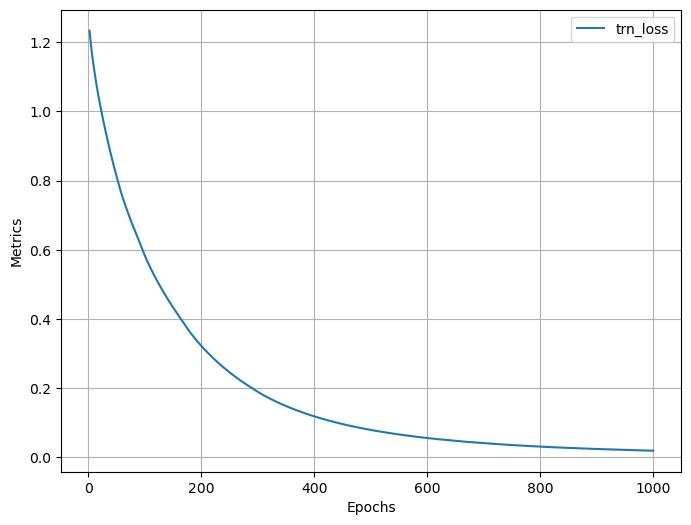

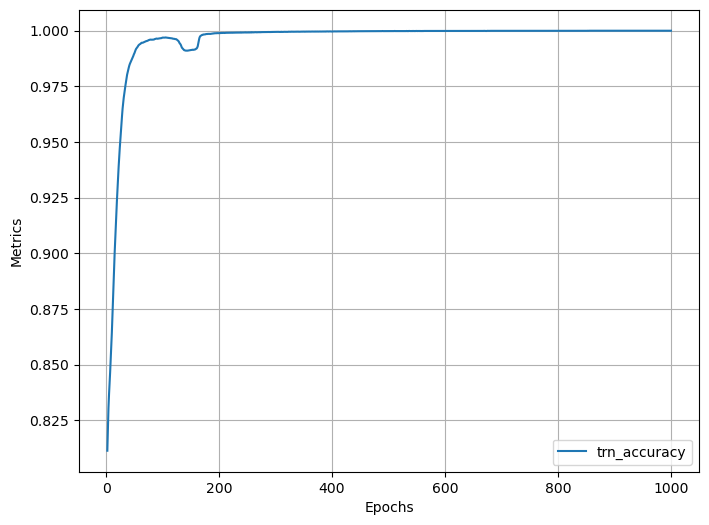

In [17]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_single_image_frozen_encoder")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=True,
    use_lr_scheduler=False
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.715  trn_accuracy: 0.251  (0.06s - 55.81s remaining)
EPOCH: 2.000  trn_loss: 1.688  trn_accuracy: 0.267  (0.10s - 48.94s remaining)
EPOCH: 3.000  trn_loss: 1.663  trn_accuracy: 0.283  (0.14s - 46.63s remaining)
EPOCH: 4.000  trn_loss: 1.639  trn_accuracy: 0.302  (0.18s - 45.77s remaining)
EPOCH: 5.000  trn_loss: 1.616  trn_accuracy: 0.320  (0.24s - 47.21s remaining)
EPOCH: 6.000  trn_loss: 1.594  trn_accuracy: 0.340  (0.28s - 46.40s remaining)
EPOCH: 7.000  trn_loss: 1.573  trn_accuracy: 0.363  (0.32s - 45.52s remaining)
EPOCH: 8.000  trn_loss: 1.553  trn_accuracy: 0.387  (0.36s - 44.85s remaining)
EPOCH: 9.000  trn_loss: 1.535  trn_accuracy: 0.411  (0.40s - 44.33s remaining)
EPOCH: 10.000  trn_loss: 1.518  trn_accuracy: 0.440  (0.44s - 43.97s remaining)
EPOCH: 11.000  trn_loss: 1.502  trn_accuracy: 0.470  (0.49s - 43.90s remaining)
EPOCH: 1

100%|██████████| 76/76 [00:12<00:00,  6.18it/s]


EPOCH: 201.000  trn_loss: 0.422  trn_accuracy: 0.998  (21.16s - 84.11s remaining)
EPOCH: 202.000  trn_loss: 0.420  trn_accuracy: 0.998  (21.21s - 83.77s remaining)
EPOCH: 203.000  trn_loss: 0.417  trn_accuracy: 0.998  (21.25s - 83.44s remaining)
EPOCH: 204.000  trn_loss: 0.415  trn_accuracy: 0.998  (21.30s - 83.10s remaining)
EPOCH: 205.000  trn_loss: 0.413  trn_accuracy: 0.998  (21.34s - 82.77s remaining)
EPOCH: 206.000  trn_loss: 0.410  trn_accuracy: 0.998  (21.39s - 82.45s remaining)
EPOCH: 207.000  trn_loss: 0.408  trn_accuracy: 0.998  (21.44s - 82.13s remaining)
EPOCH: 208.000  trn_loss: 0.406  trn_accuracy: 0.998  (21.48s - 81.81s remaining)
EPOCH: 209.000  trn_loss: 0.403  trn_accuracy: 0.998  (21.53s - 81.49s remaining)
EPOCH: 210.000  trn_loss: 0.401  trn_accuracy: 0.998  (21.58s - 81.17s remaining)
EPOCH: 211.000  trn_loss: 0.399  trn_accuracy: 0.998  (21.62s - 80.86s remaining)
EPOCH: 212.000  trn_loss: 0.397  trn_accuracy: 0.998  (21.67s - 80.55s remaining)
EPOCH: 213.000  

100%|██████████| 76/76 [00:11<00:00,  6.89it/s]


EPOCH: 401.000  trn_loss: 0.154  trn_accuracy: 0.999  (41.34s - 61.75s remaining)
EPOCH: 402.000  trn_loss: 0.154  trn_accuracy: 0.999  (41.38s - 61.55s remaining)
EPOCH: 403.000  trn_loss: 0.153  trn_accuracy: 0.999  (41.42s - 61.36s remaining)
EPOCH: 404.000  trn_loss: 0.152  trn_accuracy: 0.999  (41.46s - 61.17s remaining)
EPOCH: 405.000  trn_loss: 0.152  trn_accuracy: 0.999  (41.50s - 60.97s remaining)
EPOCH: 406.000  trn_loss: 0.151  trn_accuracy: 0.999  (41.55s - 60.78s remaining)
EPOCH: 407.000  trn_loss: 0.150  trn_accuracy: 1.000  (41.59s - 60.59s remaining)
EPOCH: 408.000  trn_loss: 0.150  trn_accuracy: 0.999  (41.63s - 60.40s remaining)
EPOCH: 409.000  trn_loss: 0.149  trn_accuracy: 0.999  (41.67s - 60.21s remaining)
EPOCH: 410.000  trn_loss: 0.148  trn_accuracy: 0.999  (41.71s - 60.02s remaining)
EPOCH: 411.000  trn_loss: 0.148  trn_accuracy: 0.999  (41.75s - 59.84s remaining)
EPOCH: 412.000  trn_loss: 0.147  trn_accuracy: 1.000  (41.80s - 59.65s remaining)
EPOCH: 413.000  

100%|██████████| 76/76 [00:11<00:00,  6.54it/s]


EPOCH: 601.000  trn_loss: 0.072  trn_accuracy: 1.000  (61.47s - 40.81s remaining)
EPOCH: 602.000  trn_loss: 0.071  trn_accuracy: 1.000  (61.52s - 40.67s remaining)
EPOCH: 603.000  trn_loss: 0.071  trn_accuracy: 1.000  (61.56s - 40.53s remaining)
EPOCH: 604.000  trn_loss: 0.071  trn_accuracy: 1.000  (61.60s - 40.39s remaining)
EPOCH: 605.000  trn_loss: 0.071  trn_accuracy: 1.000  (61.65s - 40.25s remaining)
EPOCH: 606.000  trn_loss: 0.070  trn_accuracy: 1.000  (61.69s - 40.11s remaining)
EPOCH: 607.000  trn_loss: 0.070  trn_accuracy: 1.000  (61.73s - 39.97s remaining)
EPOCH: 608.000  trn_loss: 0.070  trn_accuracy: 1.000  (61.77s - 39.83s remaining)
EPOCH: 609.000  trn_loss: 0.070  trn_accuracy: 1.000  (61.82s - 39.69s remaining)
EPOCH: 610.000  trn_loss: 0.070  trn_accuracy: 1.000  (61.86s - 39.55s remaining)
EPOCH: 611.000  trn_loss: 0.069  trn_accuracy: 1.000  (61.90s - 39.41s remaining)
EPOCH: 612.000  trn_loss: 0.069  trn_accuracy: 1.000  (61.95s - 39.27s remaining)
EPOCH: 613.000  

100%|██████████| 76/76 [00:10<00:00,  6.98it/s]


EPOCH: 801.000  trn_loss: 0.040  trn_accuracy: 1.000  (81.65s - 20.28s remaining)
EPOCH: 802.000  trn_loss: 0.040  trn_accuracy: 1.000  (81.69s - 20.17s remaining)
EPOCH: 803.000  trn_loss: 0.039  trn_accuracy: 1.000  (81.74s - 20.05s remaining)
EPOCH: 804.000  trn_loss: 0.039  trn_accuracy: 1.000  (81.78s - 19.94s remaining)
EPOCH: 805.000  trn_loss: 0.039  trn_accuracy: 1.000  (81.82s - 19.82s remaining)
EPOCH: 806.000  trn_loss: 0.039  trn_accuracy: 1.000  (81.86s - 19.70s remaining)
EPOCH: 807.000  trn_loss: 0.039  trn_accuracy: 1.000  (81.91s - 19.59s remaining)
EPOCH: 808.000  trn_loss: 0.039  trn_accuracy: 1.000  (81.96s - 19.48s remaining)
EPOCH: 809.000  trn_loss: 0.039  trn_accuracy: 1.000  (82.00s - 19.36s remaining)
EPOCH: 810.000  trn_loss: 0.039  trn_accuracy: 1.000  (82.04s - 19.24s remaining)
EPOCH: 811.000  trn_loss: 0.039  trn_accuracy: 1.000  (82.09s - 19.13s remaining)
EPOCH: 812.000  trn_loss: 0.038  trn_accuracy: 1.000  (82.13s - 19.02s remaining)
EPOCH: 813.000  

100%|██████████| 1101/1101 [00:00<00:00, 13623.33it/s]


[INFO] Training Metrics


76it [00:03, 25.23it/s]


[INFO] Avg Accuracy: 0.979985773563385 +/- 0.009389880113303661
[INFO] Avg Dice: 0.25268618307549073 +/- 0.28659671719627344
[INFO] Test Metrics


20it [00:00, 23.33it/s]

[INFO] Avg Accuracy: 0.9788559079170227 +/- 0.0063428087159991264
[INFO] Avg Dice: 0.19061723917304182 +/- 0.203469470847001


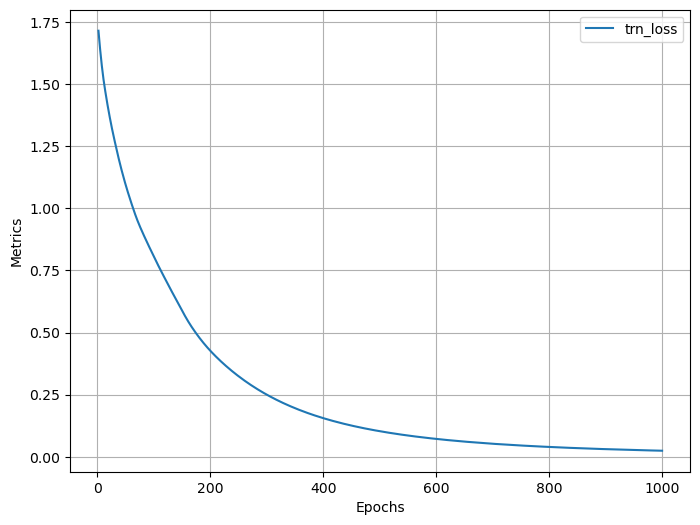

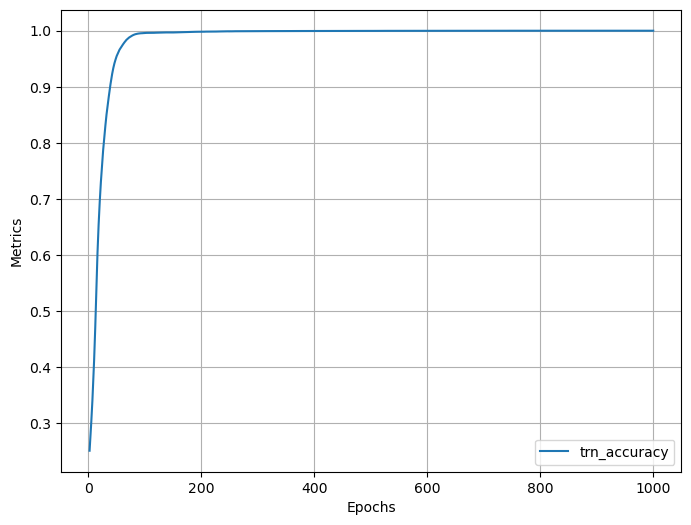

In [18]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_single_image_fixed_lr")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=False
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.189  trn_accuracy: 0.882  (0.04s - 42.50s remaining)
EPOCH: 2.000  trn_loss: 1.189  trn_accuracy: 0.882  (0.08s - 41.28s remaining)
EPOCH: 3.000  trn_loss: 1.189  trn_accuracy: 0.882  (0.12s - 41.33s remaining)
EPOCH: 4.000  trn_loss: 1.189  trn_accuracy: 0.882  (0.17s - 41.50s remaining)
EPOCH: 5.000  trn_loss: 1.188  trn_accuracy: 0.882  (0.21s - 41.76s remaining)
EPOCH: 6.000  trn_loss: 1.188  trn_accuracy: 0.882  (0.25s - 41.95s remaining)
EPOCH: 7.000  trn_loss: 1.187  trn_accuracy: 0.883  (0.30s - 41.92s remaining)
EPOCH: 8.000  trn_loss: 1.187  trn_accuracy: 0.883  (0.34s - 41.88s remaining)
EPOCH: 9.000  trn_loss: 1.186  trn_accuracy: 0.883  (0.38s - 41.84s remaining)
EPOCH: 10.000  trn_loss: 1.186  trn_accuracy: 0.883  (0.42s - 41.91s remaining)
EPOCH: 11.000  trn_loss: 1.185  trn_accuracy: 0.883  (0.48s - 43.26s remaining)
EPOCH: 1

100%|██████████| 76/76 [00:11<00:00,  6.45it/s]


EPOCH: 201.000  trn_loss: 0.695  trn_accuracy: 0.986  (20.53s - 81.63s remaining)
EPOCH: 202.000  trn_loss: 0.692  trn_accuracy: 0.986  (20.58s - 81.28s remaining)
EPOCH: 203.000  trn_loss: 0.690  trn_accuracy: 0.986  (20.62s - 80.94s remaining)
EPOCH: 204.000  trn_loss: 0.687  trn_accuracy: 0.986  (20.66s - 80.61s remaining)
EPOCH: 205.000  trn_loss: 0.684  trn_accuracy: 0.986  (20.70s - 80.28s remaining)
EPOCH: 206.000  trn_loss: 0.682  trn_accuracy: 0.987  (20.74s - 79.95s remaining)
EPOCH: 207.000  trn_loss: 0.679  trn_accuracy: 0.987  (20.79s - 79.64s remaining)
EPOCH: 208.000  trn_loss: 0.677  trn_accuracy: 0.987  (20.83s - 79.32s remaining)
EPOCH: 209.000  trn_loss: 0.674  trn_accuracy: 0.987  (20.87s - 79.00s remaining)
EPOCH: 210.000  trn_loss: 0.672  trn_accuracy: 0.987  (20.91s - 78.68s remaining)
EPOCH: 211.000  trn_loss: 0.669  trn_accuracy: 0.987  (20.96s - 78.37s remaining)
EPOCH: 212.000  trn_loss: 0.666  trn_accuracy: 0.987  (21.00s - 78.06s remaining)
EPOCH: 213.000  

100%|██████████| 76/76 [00:11<00:00,  6.49it/s]


EPOCH: 401.000  trn_loss: 0.283  trn_accuracy: 0.998  (41.23s - 61.59s remaining)
EPOCH: 402.000  trn_loss: 0.281  trn_accuracy: 0.998  (41.28s - 61.40s remaining)
EPOCH: 403.000  trn_loss: 0.280  trn_accuracy: 0.998  (41.33s - 61.22s remaining)
EPOCH: 404.000  trn_loss: 0.279  trn_accuracy: 0.998  (41.37s - 61.03s remaining)
EPOCH: 405.000  trn_loss: 0.277  trn_accuracy: 0.998  (41.42s - 60.85s remaining)
EPOCH: 406.000  trn_loss: 0.276  trn_accuracy: 0.998  (41.47s - 60.68s remaining)
EPOCH: 407.000  trn_loss: 0.275  trn_accuracy: 0.998  (41.52s - 60.49s remaining)
EPOCH: 408.000  trn_loss: 0.274  trn_accuracy: 0.998  (41.57s - 60.31s remaining)
EPOCH: 409.000  trn_loss: 0.272  trn_accuracy: 0.998  (41.61s - 60.13s remaining)
EPOCH: 410.000  trn_loss: 0.271  trn_accuracy: 0.998  (41.66s - 59.95s remaining)
EPOCH: 411.000  trn_loss: 0.270  trn_accuracy: 0.998  (41.71s - 59.78s remaining)
EPOCH: 412.000  trn_loss: 0.269  trn_accuracy: 0.998  (41.76s - 59.60s remaining)
EPOCH: 413.000  

100%|██████████| 76/76 [00:10<00:00,  6.96it/s]


EPOCH: 601.000  trn_loss: 0.132  trn_accuracy: 0.999  (61.41s - 40.77s remaining)
EPOCH: 602.000  trn_loss: 0.132  trn_accuracy: 0.999  (61.46s - 40.63s remaining)
EPOCH: 603.000  trn_loss: 0.131  trn_accuracy: 0.999  (61.50s - 40.49s remaining)
EPOCH: 604.000  trn_loss: 0.131  trn_accuracy: 0.999  (61.54s - 40.35s remaining)
EPOCH: 605.000  trn_loss: 0.130  trn_accuracy: 0.999  (61.59s - 40.21s remaining)
EPOCH: 606.000  trn_loss: 0.130  trn_accuracy: 0.999  (61.63s - 40.07s remaining)
EPOCH: 607.000  trn_loss: 0.129  trn_accuracy: 0.999  (61.68s - 39.93s remaining)
EPOCH: 608.000  trn_loss: 0.129  trn_accuracy: 0.999  (61.72s - 39.79s remaining)
EPOCH: 609.000  trn_loss: 0.129  trn_accuracy: 0.999  (61.76s - 39.65s remaining)
EPOCH: 610.000  trn_loss: 0.128  trn_accuracy: 0.999  (61.81s - 39.52s remaining)
EPOCH: 611.000  trn_loss: 0.128  trn_accuracy: 0.999  (61.85s - 39.38s remaining)
EPOCH: 612.000  trn_loss: 0.127  trn_accuracy: 0.999  (61.89s - 39.24s remaining)
EPOCH: 613.000  

100%|██████████| 76/76 [00:11<00:00,  6.39it/s]


EPOCH: 801.000  trn_loss: 0.068  trn_accuracy: 1.000  (82.13s - 20.40s remaining)
EPOCH: 802.000  trn_loss: 0.068  trn_accuracy: 1.000  (82.18s - 20.29s remaining)
EPOCH: 803.000  trn_loss: 0.068  trn_accuracy: 1.000  (82.22s - 20.17s remaining)
EPOCH: 804.000  trn_loss: 0.067  trn_accuracy: 1.000  (82.27s - 20.06s remaining)
EPOCH: 805.000  trn_loss: 0.067  trn_accuracy: 1.000  (82.31s - 19.94s remaining)
EPOCH: 806.000  trn_loss: 0.067  trn_accuracy: 1.000  (82.37s - 19.82s remaining)
EPOCH: 807.000  trn_loss: 0.067  trn_accuracy: 1.000  (82.41s - 19.71s remaining)
EPOCH: 808.000  trn_loss: 0.067  trn_accuracy: 1.000  (82.46s - 19.59s remaining)
EPOCH: 809.000  trn_loss: 0.066  trn_accuracy: 1.000  (82.50s - 19.48s remaining)
EPOCH: 810.000  trn_loss: 0.066  trn_accuracy: 1.000  (82.55s - 19.36s remaining)
EPOCH: 811.000  trn_loss: 0.066  trn_accuracy: 1.000  (82.60s - 19.25s remaining)
EPOCH: 812.000  trn_loss: 0.066  trn_accuracy: 1.000  (82.65s - 19.14s remaining)
EPOCH: 813.000  

100%|██████████| 1101/1101 [00:00<00:00, 12501.03it/s]


[INFO] Training Metrics


76it [00:02, 26.27it/s]


[INFO] Avg Accuracy: 0.9780775308609009 +/- 0.011009687557816505
[INFO] Avg Dice: 0.3235939921934552 +/- 0.34080138945010874
[INFO] Test Metrics


20it [00:00, 22.48it/s]

[INFO] Avg Accuracy: 0.9754625558853149 +/- 0.00835330132395029
[INFO] Avg Dice: 0.2825079213669187 +/- 0.29606730272843707


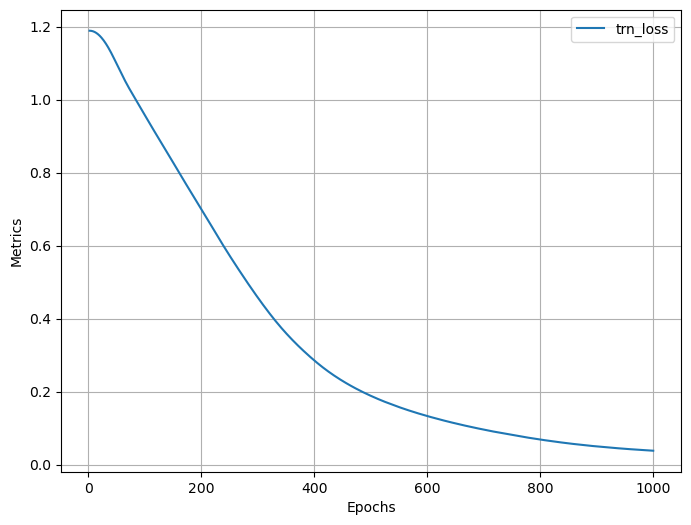

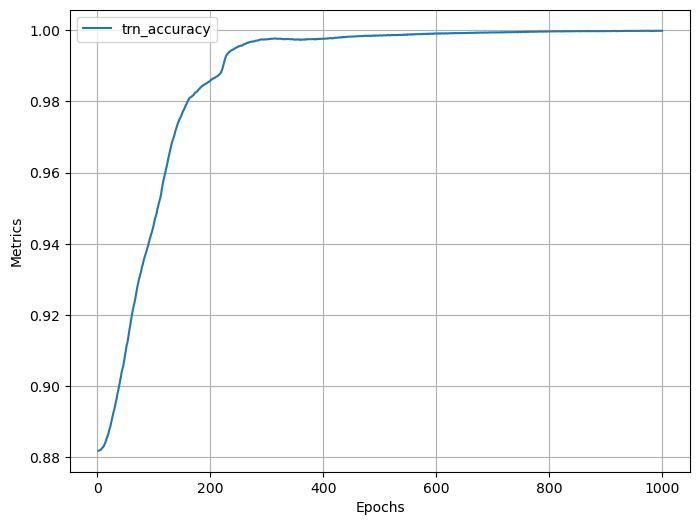

In [19]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_single_image_lr_scheduler")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=True
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

### Load weights and train the model on the whole train data and test on the whole test data

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.585  trn_accuracy: 0.901  (3.25s - 3246.45s remaining)
EPOCH: 2.000  trn_loss: 1.487  trn_accuracy: 0.936  (6.39s - 3188.40s remaining)
EPOCH: 3.000  trn_loss: 1.411  trn_accuracy: 0.945  (9.56s - 3177.29s remaining)
EPOCH: 4.000  trn_loss: 1.350  trn_accuracy: 0.949  (12.75s - 3174.07s remaining)
EPOCH: 5.000  trn_loss: 1.312  trn_accuracy: 0.952  (15.93s - 3170.38s remaining)
EPOCH: 6.000  trn_loss: 1.288  trn_accuracy: 0.954  (19.13s - 3169.11s remaining)
EPOCH: 7.000  trn_loss: 1.270  trn_accuracy: 0.961  (22.33s - 3167.88s remaining)
EPOCH: 8.000  trn_loss: 1.257  trn_accuracy: 0.965  (25.55s - 3168.31s remaining)
EPOCH: 9.000  trn_loss: 1.249  trn_accuracy: 0.966  (28.88s - 3179.51s remaining)
EPOCH: 10.000  trn_loss: 1.243  trn_accuracy: 0.967  (32.34s - 3201.99s remaining)
EPOCH: 11.000  trn_loss: 1.239  trn_accuracy: 0.969  (35.61s 

100%|██████████| 76/76 [00:12<00:00,  6.02it/s]


EPOCH: 201.000  trn_loss: 0.196  trn_accuracy: 1.000  (693.63s - 2757.28s remaining)
EPOCH: 202.000  trn_loss: 0.196  trn_accuracy: 1.000  (697.05s - 2753.70s remaining)
EPOCH: 203.000  trn_loss: 0.196  trn_accuracy: 1.000  (700.25s - 2749.28s remaining)
EPOCH: 204.000  trn_loss: 0.196  trn_accuracy: 1.000  (703.51s - 2745.06s remaining)
EPOCH: 205.000  trn_loss: 0.196  trn_accuracy: 1.000  (706.72s - 2740.69s remaining)
EPOCH: 206.000  trn_loss: 0.196  trn_accuracy: 1.000  (709.91s - 2736.27s remaining)
EPOCH: 207.000  trn_loss: 0.196  trn_accuracy: 1.000  (713.14s - 2731.99s remaining)
EPOCH: 208.000  trn_loss: 0.196  trn_accuracy: 1.000  (716.95s - 2729.94s remaining)
EPOCH: 209.000  trn_loss: 0.196  trn_accuracy: 1.000  (720.22s - 2725.82s remaining)
EPOCH: 210.000  trn_loss: 0.196  trn_accuracy: 1.000  (723.48s - 2721.66s remaining)
EPOCH: 211.000  trn_loss: 0.196  trn_accuracy: 1.000  (726.71s - 2717.41s remaining)
EPOCH: 212.000  trn_loss: 0.196  trn_accuracy: 1.000  (729.92s - 

100%|██████████| 76/76 [00:13<00:00,  5.55it/s]


EPOCH: 401.000  trn_loss: 0.196  trn_accuracy: 1.000  (1384.64s - 2068.32s remaining)
EPOCH: 402.000  trn_loss: 0.196  trn_accuracy: 1.000  (1387.88s - 2064.56s remaining)
EPOCH: 403.000  trn_loss: 0.196  trn_accuracy: 1.000  (1391.33s - 2061.10s remaining)
EPOCH: 404.000  trn_loss: 0.196  trn_accuracy: 1.000  (1394.85s - 2057.75s remaining)
EPOCH: 405.000  trn_loss: 0.196  trn_accuracy: 1.000  (1398.36s - 2054.39s remaining)
EPOCH: 406.000  trn_loss: 0.196  trn_accuracy: 1.000  (1401.91s - 2051.06s remaining)
EPOCH: 407.000  trn_loss: 0.196  trn_accuracy: 1.000  (1405.69s - 2048.09s remaining)
EPOCH: 408.000  trn_loss: 0.196  trn_accuracy: 1.000  (1408.99s - 2044.42s remaining)
EPOCH: 409.000  trn_loss: 0.196  trn_accuracy: 1.000  (1412.47s - 2041.00s remaining)
EPOCH: 410.000  trn_loss: 0.196  trn_accuracy: 1.000  (1415.99s - 2037.65s remaining)
EPOCH: 411.000  trn_loss: 0.196  trn_accuracy: 1.000  (1419.51s - 2034.28s remaining)
EPOCH: 412.000  trn_loss: 0.196  trn_accuracy: 1.000  

100%|██████████| 76/76 [00:12<00:00,  6.01it/s]


EPOCH: 601.000  trn_loss: 0.196  trn_accuracy: 1.000  (2083.03s - 1382.91s remaining)
EPOCH: 602.000  trn_loss: 0.196  trn_accuracy: 1.000  (2086.25s - 1379.28s remaining)
EPOCH: 603.000  trn_loss: 0.196  trn_accuracy: 1.000  (2089.62s - 1375.75s remaining)
EPOCH: 604.000  trn_loss: 0.196  trn_accuracy: 1.000  (2093.34s - 1372.46s remaining)
EPOCH: 605.000  trn_loss: 0.196  trn_accuracy: 1.000  (2096.70s - 1368.92s remaining)
EPOCH: 606.000  trn_loss: 0.196  trn_accuracy: 1.000  (2100.20s - 1365.48s remaining)
EPOCH: 607.000  trn_loss: 0.196  trn_accuracy: 1.000  (2103.69s - 1362.03s remaining)
EPOCH: 608.000  trn_loss: 0.196  trn_accuracy: 1.000  (2106.86s - 1358.37s remaining)
EPOCH: 609.000  trn_loss: 0.196  trn_accuracy: 1.000  (2110.32s - 1354.90s remaining)
EPOCH: 610.000  trn_loss: 0.196  trn_accuracy: 1.000  (2113.67s - 1351.36s remaining)
EPOCH: 611.000  trn_loss: 0.196  trn_accuracy: 1.000  (2116.89s - 1347.74s remaining)
EPOCH: 612.000  trn_loss: 0.196  trn_accuracy: 1.000  

100%|██████████| 76/76 [00:10<00:00,  7.07it/s]


EPOCH: 801.000  trn_loss: 0.196  trn_accuracy: 1.000  (2774.68s - 689.34s remaining)
EPOCH: 802.000  trn_loss: 0.196  trn_accuracy: 1.000  (2778.15s - 685.88s remaining)
EPOCH: 803.000  trn_loss: 0.196  trn_accuracy: 1.000  (2781.89s - 682.48s remaining)
EPOCH: 804.000  trn_loss: 0.196  trn_accuracy: 1.000  (2785.26s - 678.99s remaining)
EPOCH: 805.000  trn_loss: 0.196  trn_accuracy: 1.000  (2788.47s - 675.47s remaining)
EPOCH: 806.000  trn_loss: 0.196  trn_accuracy: 1.000  (2791.69s - 671.95s remaining)
EPOCH: 807.000  trn_loss: 0.196  trn_accuracy: 1.000  (2794.88s - 668.42s remaining)
EPOCH: 808.000  trn_loss: 0.196  trn_accuracy: 1.000  (2798.10s - 664.89s remaining)
EPOCH: 809.000  trn_loss: 0.196  trn_accuracy: 1.000  (2801.35s - 661.38s remaining)
EPOCH: 810.000  trn_loss: 0.196  trn_accuracy: 1.000  (2804.68s - 657.89s remaining)
EPOCH: 811.000  trn_loss: 0.196  trn_accuracy: 1.000  (2808.45s - 654.50s remaining)
EPOCH: 812.000  trn_loss: 0.196  trn_accuracy: 1.000  (2811.89s -

100%|██████████| 1101/1101 [00:00<00:00, 13107.46it/s]


[INFO] Training Metrics


76it [00:03, 21.52it/s]


[INFO] Avg Accuracy: 0.9987807273864746 +/- 0.0025757495313882828
[INFO] Avg Dice: 0.520945521051312 +/- 0.4814076495613757
[INFO] Test Metrics


20it [00:00, 25.11it/s]


[INFO] Avg Accuracy: 0.9954913854598999 +/- 0.004484099801629782
[INFO] Avg Dice: 0.39586246071631265 +/- 0.4090545612851961


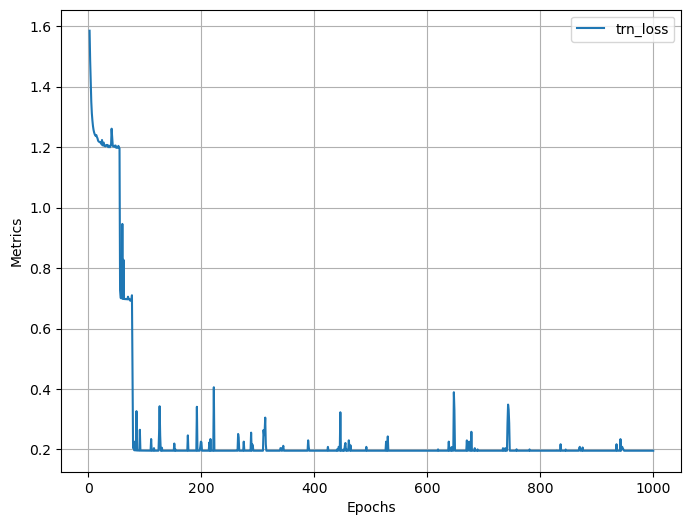

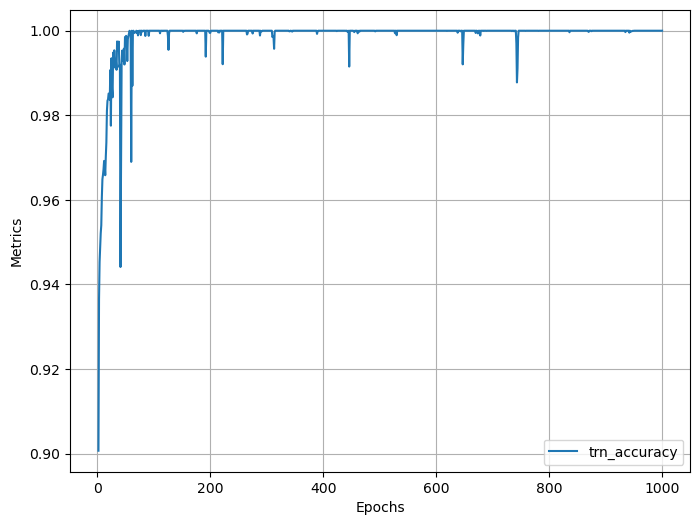

In [20]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_whole_data_frozen_encoder")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["dice_focal"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=True,
    use_lr_scheduler=False
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.765  trn_accuracy: 0.823  (3.37s - 3362.66s remaining)
EPOCH: 2.000  trn_loss: 1.648  trn_accuracy: 0.919  (6.71s - 3347.92s remaining)
EPOCH: 3.000  trn_loss: 1.548  trn_accuracy: 0.937  (10.22s - 3396.70s remaining)
EPOCH: 4.000  trn_loss: 1.467  trn_accuracy: 0.948  (13.89s - 3458.14s remaining)
EPOCH: 5.000  trn_loss: 1.415  trn_accuracy: 0.952  (17.55s - 3492.59s remaining)
EPOCH: 6.000  trn_loss: 1.378  trn_accuracy: 0.955  (21.09s - 3494.42s remaining)
EPOCH: 7.000  trn_loss: 1.347  trn_accuracy: 0.961  (25.17s - 3570.45s remaining)
EPOCH: 8.000  trn_loss: 1.307  trn_accuracy: 0.959  (28.72s - 3561.22s remaining)
EPOCH: 9.000  trn_loss: 1.285  trn_accuracy: 0.964  (32.28s - 3554.77s remaining)
EPOCH: 10.000  trn_loss: 1.274  trn_accuracy: 0.962  (35.79s - 3543.15s remaining)
EPOCH: 11.000  trn_loss: 1.267  trn_accuracy: 0.962  (39.07s

100%|██████████| 76/76 [00:11<00:00,  6.59it/s]


EPOCH: 201.000  trn_loss: 0.280  trn_accuracy: 0.998  (709.86s - 2821.77s remaining)
EPOCH: 202.000  trn_loss: 0.196  trn_accuracy: 1.000  (713.63s - 2819.18s remaining)
EPOCH: 203.000  trn_loss: 0.196  trn_accuracy: 1.000  (717.00s - 2815.02s remaining)
EPOCH: 204.000  trn_loss: 0.196  trn_accuracy: 1.000  (720.35s - 2810.79s remaining)
EPOCH: 205.000  trn_loss: 0.196  trn_accuracy: 1.000  (723.69s - 2806.49s remaining)
EPOCH: 206.000  trn_loss: 0.196  trn_accuracy: 1.000  (727.06s - 2802.35s remaining)
EPOCH: 207.000  trn_loss: 0.196  trn_accuracy: 1.000  (730.39s - 2798.08s remaining)
EPOCH: 208.000  trn_loss: 0.196  trn_accuracy: 1.000  (733.71s - 2793.74s remaining)
EPOCH: 209.000  trn_loss: 0.196  trn_accuracy: 1.000  (737.54s - 2791.35s remaining)
EPOCH: 210.000  trn_loss: 0.196  trn_accuracy: 1.000  (740.89s - 2787.16s remaining)
EPOCH: 211.000  trn_loss: 0.196  trn_accuracy: 1.000  (744.40s - 2783.57s remaining)
EPOCH: 212.000  trn_loss: 0.196  trn_accuracy: 1.000  (748.05s - 

100%|██████████| 76/76 [00:11<00:00,  6.42it/s]


EPOCH: 401.000  trn_loss: 0.196  trn_accuracy: 1.000  (1417.78s - 2117.84s remaining)
EPOCH: 402.000  trn_loss: 0.196  trn_accuracy: 1.000  (1421.43s - 2114.46s remaining)
EPOCH: 403.000  trn_loss: 0.196  trn_accuracy: 1.000  (1425.14s - 2111.18s remaining)
EPOCH: 404.000  trn_loss: 0.196  trn_accuracy: 1.000  (1428.39s - 2107.23s remaining)
EPOCH: 405.000  trn_loss: 0.196  trn_accuracy: 1.000  (1431.68s - 2103.33s remaining)
EPOCH: 406.000  trn_loss: 0.196  trn_accuracy: 1.000  (1435.06s - 2099.57s remaining)
EPOCH: 407.000  trn_loss: 0.196  trn_accuracy: 1.000  (1438.40s - 2095.75s remaining)
EPOCH: 408.000  trn_loss: 0.196  trn_accuracy: 1.000  (1441.74s - 2091.93s remaining)
EPOCH: 409.000  trn_loss: 0.196  trn_accuracy: 1.000  (1445.08s - 2088.12s remaining)
EPOCH: 410.000  trn_loss: 0.196  trn_accuracy: 1.000  (1448.47s - 2084.38s remaining)
EPOCH: 411.000  trn_loss: 0.211  trn_accuracy: 1.000  (1452.30s - 2081.27s remaining)
EPOCH: 412.000  trn_loss: 0.196  trn_accuracy: 1.000  

100%|██████████| 76/76 [00:11<00:00,  6.72it/s]


EPOCH: 601.000  trn_loss: 0.196  trn_accuracy: 1.000  (2127.05s - 1412.13s remaining)
EPOCH: 602.000  trn_loss: 0.196  trn_accuracy: 1.000  (2130.67s - 1408.65s remaining)
EPOCH: 603.000  trn_loss: 0.196  trn_accuracy: 1.000  (2134.24s - 1405.13s remaining)
EPOCH: 604.000  trn_loss: 0.196  trn_accuracy: 1.000  (2137.49s - 1401.40s remaining)
EPOCH: 605.000  trn_loss: 0.196  trn_accuracy: 1.000  (2141.29s - 1398.03s remaining)
EPOCH: 606.000  trn_loss: 0.196  trn_accuracy: 1.000  (2144.57s - 1394.32s remaining)
EPOCH: 607.000  trn_loss: 0.196  trn_accuracy: 1.000  (2147.88s - 1390.63s remaining)
EPOCH: 608.000  trn_loss: 0.196  trn_accuracy: 1.000  (2151.27s - 1387.00s remaining)
EPOCH: 609.000  trn_loss: 0.196  trn_accuracy: 1.000  (2154.77s - 1383.44s remaining)
EPOCH: 610.000  trn_loss: 0.196  trn_accuracy: 1.000  (2158.07s - 1379.75s remaining)
EPOCH: 611.000  trn_loss: 0.196  trn_accuracy: 1.000  (2161.35s - 1376.05s remaining)
EPOCH: 612.000  trn_loss: 0.196  trn_accuracy: 1.000  

100%|██████████| 76/76 [00:10<00:00,  7.01it/s]


EPOCH: 801.000  trn_loss: 0.196  trn_accuracy: 1.000  (2833.38s - 703.92s remaining)
EPOCH: 802.000  trn_loss: 0.196  trn_accuracy: 1.000  (2836.94s - 700.39s remaining)
EPOCH: 803.000  trn_loss: 0.196  trn_accuracy: 1.000  (2840.37s - 696.83s remaining)
EPOCH: 804.000  trn_loss: 0.196  trn_accuracy: 1.000  (2843.79s - 693.26s remaining)
EPOCH: 805.000  trn_loss: 0.196  trn_accuracy: 1.000  (2847.04s - 689.66s remaining)
EPOCH: 806.000  trn_loss: 0.196  trn_accuracy: 1.000  (2850.32s - 686.06s remaining)
EPOCH: 807.000  trn_loss: 0.196  trn_accuracy: 1.000  (2853.59s - 682.46s remaining)
EPOCH: 808.000  trn_loss: 0.196  trn_accuracy: 1.000  (2857.38s - 678.98s remaining)
EPOCH: 809.000  trn_loss: 0.196  trn_accuracy: 1.000  (2860.66s - 675.39s remaining)
EPOCH: 810.000  trn_loss: 0.196  trn_accuracy: 1.000  (2863.96s - 671.79s remaining)
EPOCH: 811.000  trn_loss: 0.198  trn_accuracy: 1.000  (2867.34s - 668.22s remaining)
EPOCH: 812.000  trn_loss: 0.196  trn_accuracy: 1.000  (2870.93s -

100%|██████████| 1101/1101 [00:00<00:00, 12329.67it/s]


[INFO] Training Metrics


76it [00:03, 22.89it/s]


[INFO] Avg Accuracy: 0.9986150860786438 +/- 0.002624418120831251
[INFO] Avg Dice: 0.5064371946306129 +/- 0.48054246491283986
[INFO] Test Metrics


20it [00:00, 22.24it/s]

[INFO] Avg Accuracy: 0.9957916140556335 +/- 0.003573224414139986
[INFO] Avg Dice: 0.42413754450663077 +/- 0.42999799443537456


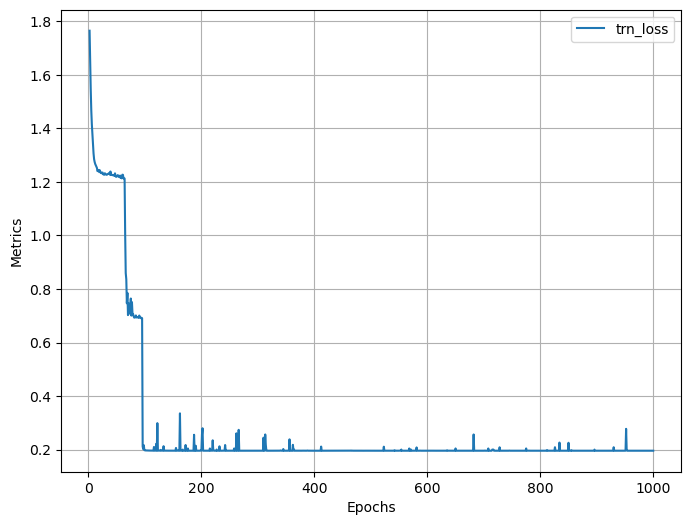

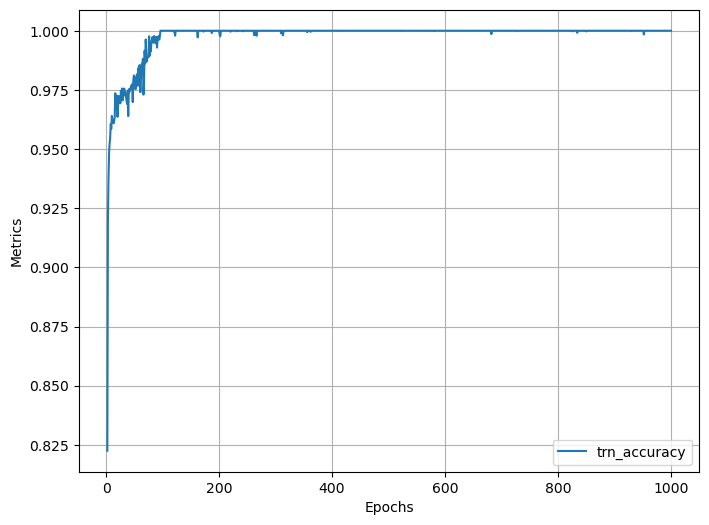

In [21]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_whole_data_fixed_lr")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["dice_focal"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=False
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.801  trn_accuracy: 0.441  (3.43s - 3423.02s remaining)
EPOCH: 2.000  trn_loss: 1.799  trn_accuracy: 0.447  (7.09s - 3539.22s remaining)
EPOCH: 3.000  trn_loss: 1.797  trn_accuracy: 0.457  (10.79s - 3585.58s remaining)
EPOCH: 4.000  trn_loss: 1.793  trn_accuracy: 0.472  (14.43s - 3593.26s remaining)
EPOCH: 5.000  trn_loss: 1.789  trn_accuracy: 0.491  (18.12s - 3605.26s remaining)
EPOCH: 6.000  trn_loss: 1.783  trn_accuracy: 0.514  (22.08s - 3658.30s remaining)
EPOCH: 7.000  trn_loss: 1.777  trn_accuracy: 0.541  (25.64s - 3636.73s remaining)
EPOCH: 8.000  trn_loss: 1.769  trn_accuracy: 0.569  (29.19s - 3619.02s remaining)
EPOCH: 9.000  trn_loss: 1.760  trn_accuracy: 0.596  (32.73s - 3604.06s remaining)
EPOCH: 10.000  trn_loss: 1.750  trn_accuracy: 0.621  (36.28s - 3591.62s remaining)
EPOCH: 11.000  trn_loss: 1.739  trn_accuracy: 0.643  (39.86s

100%|██████████| 76/76 [00:10<00:00,  7.37it/s]


EPOCH: 201.000  trn_loss: 0.688  trn_accuracy: 1.000  (712.21s - 2831.13s remaining)
EPOCH: 202.000  trn_loss: 0.684  trn_accuracy: 1.000  (716.21s - 2829.39s remaining)
EPOCH: 203.000  trn_loss: 0.684  trn_accuracy: 1.000  (719.75s - 2825.83s remaining)
EPOCH: 204.000  trn_loss: 0.684  trn_accuracy: 1.000  (723.14s - 2821.68s remaining)
EPOCH: 205.000  trn_loss: 0.706  trn_accuracy: 0.999  (726.55s - 2817.59s remaining)
EPOCH: 206.000  trn_loss: 0.688  trn_accuracy: 1.000  (730.12s - 2814.17s remaining)
EPOCH: 207.000  trn_loss: 0.684  trn_accuracy: 1.000  (733.78s - 2811.07s remaining)
EPOCH: 208.000  trn_loss: 0.684  trn_accuracy: 1.000  (737.44s - 2807.96s remaining)
EPOCH: 209.000  trn_loss: 0.688  trn_accuracy: 1.000  (741.05s - 2804.65s remaining)
EPOCH: 210.000  trn_loss: 0.684  trn_accuracy: 1.000  (745.05s - 2802.80s remaining)
EPOCH: 211.000  trn_loss: 0.684  trn_accuracy: 1.000  (748.36s - 2798.37s remaining)
EPOCH: 212.000  trn_loss: 0.684  trn_accuracy: 1.000  (751.65s - 

100%|██████████| 76/76 [00:11<00:00,  6.71it/s]


EPOCH: 401.000  trn_loss: 0.291  trn_accuracy: 0.997  (1424.79s - 2128.30s remaining)
EPOCH: 402.000  trn_loss: 0.196  trn_accuracy: 1.000  (1428.41s - 2124.85s remaining)
EPOCH: 403.000  trn_loss: 0.209  trn_accuracy: 1.000  (1432.01s - 2121.36s remaining)
EPOCH: 404.000  trn_loss: 0.196  trn_accuracy: 1.000  (1435.89s - 2118.30s remaining)
EPOCH: 405.000  trn_loss: 0.196  trn_accuracy: 1.000  (1439.13s - 2114.28s remaining)
EPOCH: 406.000  trn_loss: 0.196  trn_accuracy: 1.000  (1442.73s - 2110.79s remaining)
EPOCH: 407.000  trn_loss: 0.196  trn_accuracy: 1.000  (1446.05s - 2106.89s remaining)
EPOCH: 408.000  trn_loss: 0.196  trn_accuracy: 1.000  (1449.24s - 2102.81s remaining)
EPOCH: 409.000  trn_loss: 0.196  trn_accuracy: 1.000  (1452.50s - 2098.84s remaining)
EPOCH: 410.000  trn_loss: 0.196  trn_accuracy: 1.000  (1455.69s - 2094.77s remaining)
EPOCH: 411.000  trn_loss: 0.196  trn_accuracy: 1.000  (1459.14s - 2091.07s remaining)
EPOCH: 412.000  trn_loss: 0.196  trn_accuracy: 1.000  

100%|██████████| 76/76 [00:11<00:00,  6.69it/s]


EPOCH: 601.000  trn_loss: 0.196  trn_accuracy: 1.000  (2130.47s - 1414.40s remaining)
EPOCH: 602.000  trn_loss: 0.204  trn_accuracy: 1.000  (2134.13s - 1410.94s remaining)
EPOCH: 603.000  trn_loss: 0.196  trn_accuracy: 1.000  (2137.70s - 1407.41s remaining)
EPOCH: 604.000  trn_loss: 0.222  trn_accuracy: 1.000  (2141.05s - 1403.73s remaining)
EPOCH: 605.000  trn_loss: 0.196  trn_accuracy: 1.000  (2144.54s - 1400.16s remaining)
EPOCH: 606.000  trn_loss: 0.196  trn_accuracy: 1.000  (2148.38s - 1396.80s remaining)
EPOCH: 607.000  trn_loss: 0.196  trn_accuracy: 1.000  (2151.70s - 1393.11s remaining)
EPOCH: 608.000  trn_loss: 0.196  trn_accuracy: 1.000  (2155.01s - 1389.42s remaining)
EPOCH: 609.000  trn_loss: 0.196  trn_accuracy: 1.000  (2158.31s - 1385.71s remaining)
EPOCH: 610.000  trn_loss: 0.196  trn_accuracy: 1.000  (2161.60s - 1382.00s remaining)
EPOCH: 611.000  trn_loss: 0.196  trn_accuracy: 1.000  (2164.91s - 1378.31s remaining)
EPOCH: 612.000  trn_loss: 0.196  trn_accuracy: 1.000  

100%|██████████| 76/76 [00:11<00:00,  6.58it/s]


EPOCH: 801.000  trn_loss: 0.196  trn_accuracy: 1.000  (2838.82s - 705.27s remaining)
EPOCH: 802.000  trn_loss: 0.196  trn_accuracy: 1.000  (2842.25s - 701.70s remaining)
EPOCH: 803.000  trn_loss: 0.196  trn_accuracy: 1.000  (2845.51s - 698.09s remaining)
EPOCH: 804.000  trn_loss: 0.196  trn_accuracy: 1.000  (2848.87s - 694.50s remaining)
EPOCH: 805.000  trn_loss: 0.196  trn_accuracy: 1.000  (2852.49s - 690.97s remaining)
EPOCH: 806.000  trn_loss: 0.196  trn_accuracy: 1.000  (2855.89s - 687.40s remaining)
EPOCH: 807.000  trn_loss: 0.196  trn_accuracy: 1.000  (2859.15s - 683.79s remaining)
EPOCH: 808.000  trn_loss: 0.196  trn_accuracy: 1.000  (2862.96s - 680.31s remaining)
EPOCH: 809.000  trn_loss: 0.196  trn_accuracy: 1.000  (2866.48s - 676.76s remaining)
EPOCH: 810.000  trn_loss: 0.196  trn_accuracy: 1.000  (2870.17s - 673.25s remaining)
EPOCH: 811.000  trn_loss: 0.196  trn_accuracy: 1.000  (2873.84s - 669.74s remaining)
EPOCH: 812.000  trn_loss: 0.196  trn_accuracy: 1.000  (2877.52s -

100%|██████████| 1101/1101 [00:00<00:00, 13772.61it/s]


[INFO] Training Metrics


76it [00:03, 24.07it/s]


[INFO] Avg Accuracy: 0.9981808066368103 +/- 0.0031011649407446384
[INFO] Avg Dice: 0.49832699569615385 +/- 0.4732758023154195
[INFO] Test Metrics


20it [00:00, 22.88it/s]

[INFO] Avg Accuracy: 0.995715320110321 +/- 0.0033049180638045073
[INFO] Avg Dice: 0.4244935441799697 +/- 0.4295187162536365


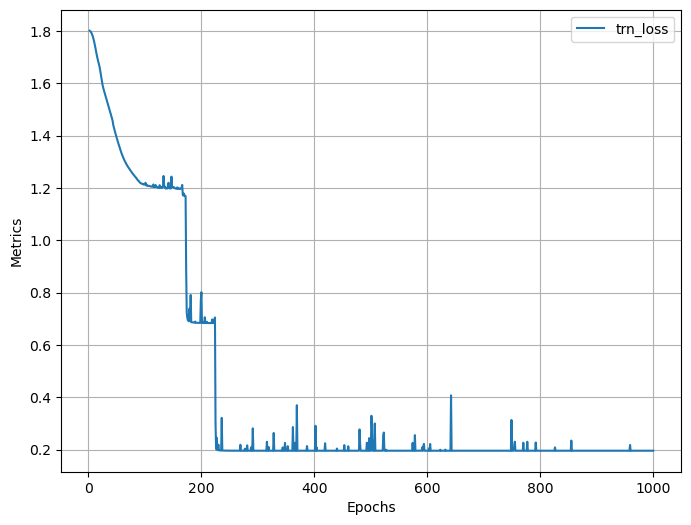

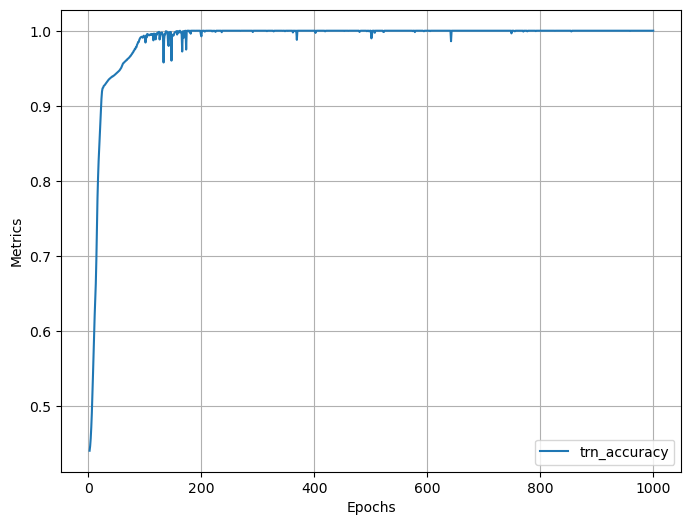

In [22]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_whole_data_lr_scheduler")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["dice_focal"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=True
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

### Load weights and train model on reduced train data and test on the whole dataset

In [23]:
n_reduced_data = int(0.10 * len(train_images))

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.637  trn_accuracy: 0.907  (0.33s - 327.13s remaining)
EPOCH: 2.000  trn_loss: 1.609  trn_accuracy: 0.938  (0.62s - 311.64s remaining)
EPOCH: 3.000  trn_loss: 1.587  trn_accuracy: 0.951  (0.98s - 326.59s remaining)
EPOCH: 4.000  trn_loss: 1.569  trn_accuracy: 0.961  (1.28s - 317.61s remaining)
EPOCH: 5.000  trn_loss: 1.550  trn_accuracy: 0.969  (1.57s - 312.83s remaining)
EPOCH: 6.000  trn_loss: 1.532  trn_accuracy: 0.972  (2.13s - 352.79s remaining)
EPOCH: 7.000  trn_loss: 1.514  trn_accuracy: 0.974  (2.68s - 379.77s remaining)
EPOCH: 8.000  trn_loss: 1.497  trn_accuracy: 0.976  (2.97s - 368.11s remaining)
EPOCH: 9.000  trn_loss: 1.479  trn_accuracy: 0.977  (3.26s - 359.24s remaining)
EPOCH: 10.000  trn_loss: 1.463  trn_accuracy: 0.978  (3.57s - 352.97s remaining)
EPOCH: 11.000  trn_loss: 1.447  trn_accuracy: 0.979  (3.86s - 346.86s remainin

100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


EPOCH: 201.000  trn_loss: 0.996  trn_accuracy: 0.998  (64.19s - 255.15s remaining)
EPOCH: 202.000  trn_loss: 0.997  trn_accuracy: 0.998  (64.52s - 254.88s remaining)
EPOCH: 203.000  trn_loss: 0.997  trn_accuracy: 0.998  (64.85s - 254.61s remaining)
EPOCH: 204.000  trn_loss: 0.998  trn_accuracy: 0.998  (65.14s - 254.18s remaining)
EPOCH: 205.000  trn_loss: 0.999  trn_accuracy: 0.998  (65.43s - 253.75s remaining)
EPOCH: 206.000  trn_loss: 0.997  trn_accuracy: 0.998  (65.73s - 253.34s remaining)
EPOCH: 207.000  trn_loss: 0.996  trn_accuracy: 0.998  (66.02s - 252.91s remaining)
EPOCH: 208.000  trn_loss: 0.997  trn_accuracy: 0.998  (66.31s - 252.49s remaining)
EPOCH: 209.000  trn_loss: 0.997  trn_accuracy: 0.998  (66.61s - 252.08s remaining)
EPOCH: 210.000  trn_loss: 0.997  trn_accuracy: 0.998  (66.90s - 251.66s remaining)
EPOCH: 211.000  trn_loss: 0.996  trn_accuracy: 0.998  (67.19s - 251.25s remaining)
EPOCH: 212.000  trn_loss: 0.996  trn_accuracy: 0.998  (67.49s - 250.85s remaining)
EPOC

100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


EPOCH: 401.000  trn_loss: 0.974  trn_accuracy: 1.000  (127.84s - 190.96s remaining)
EPOCH: 402.000  trn_loss: 0.972  trn_accuracy: 1.000  (128.14s - 190.62s remaining)
EPOCH: 403.000  trn_loss: 0.970  trn_accuracy: 1.000  (128.45s - 190.28s remaining)
EPOCH: 404.000  trn_loss: 0.969  trn_accuracy: 1.000  (128.75s - 189.94s remaining)
EPOCH: 405.000  trn_loss: 0.969  trn_accuracy: 1.000  (129.05s - 189.59s remaining)
EPOCH: 406.000  trn_loss: 0.968  trn_accuracy: 1.000  (129.35s - 189.24s remaining)
EPOCH: 407.000  trn_loss: 0.967  trn_accuracy: 1.000  (129.67s - 188.93s remaining)
EPOCH: 408.000  trn_loss: 0.967  trn_accuracy: 1.000  (130.00s - 188.62s remaining)
EPOCH: 409.000  trn_loss: 0.966  trn_accuracy: 1.000  (130.33s - 188.32s remaining)
EPOCH: 410.000  trn_loss: 0.966  trn_accuracy: 1.000  (130.66s - 188.03s remaining)
EPOCH: 411.000  trn_loss: 0.966  trn_accuracy: 1.000  (130.99s - 187.73s remaining)
EPOCH: 412.000  trn_loss: 0.966  trn_accuracy: 1.000  (131.33s - 187.43s rem

100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


EPOCH: 601.000  trn_loss: 0.579  trn_accuracy: 1.000  (192.99s - 128.13s remaining)
EPOCH: 602.000  trn_loss: 0.576  trn_accuracy: 1.000  (193.29s - 127.79s remaining)
EPOCH: 603.000  trn_loss: 0.581  trn_accuracy: 0.999  (193.59s - 127.46s remaining)
EPOCH: 604.000  trn_loss: 0.575  trn_accuracy: 1.000  (193.90s - 127.12s remaining)
EPOCH: 605.000  trn_loss: 0.574  trn_accuracy: 1.000  (194.19s - 126.79s remaining)
EPOCH: 606.000  trn_loss: 0.574  trn_accuracy: 1.000  (194.50s - 126.46s remaining)
EPOCH: 607.000  trn_loss: 0.573  trn_accuracy: 1.000  (194.85s - 126.15s remaining)
EPOCH: 608.000  trn_loss: 0.575  trn_accuracy: 1.000  (195.18s - 125.84s remaining)
EPOCH: 609.000  trn_loss: 0.574  trn_accuracy: 1.000  (195.51s - 125.53s remaining)
EPOCH: 610.000  trn_loss: 0.573  trn_accuracy: 1.000  (195.83s - 125.20s remaining)
EPOCH: 611.000  trn_loss: 0.574  trn_accuracy: 1.000  (196.12s - 124.86s remaining)
EPOCH: 612.000  trn_loss: 0.572  trn_accuracy: 1.000  (196.42s - 124.52s rem

100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


EPOCH: 801.000  trn_loss: 0.196  trn_accuracy: 1.000  (258.68s - 64.27s remaining)
EPOCH: 802.000  trn_loss: 0.196  trn_accuracy: 1.000  (259.00s - 63.94s remaining)
EPOCH: 803.000  trn_loss: 0.196  trn_accuracy: 1.000  (259.33s - 63.62s remaining)
EPOCH: 804.000  trn_loss: 0.196  trn_accuracy: 1.000  (259.66s - 63.30s remaining)
EPOCH: 805.000  trn_loss: 0.197  trn_accuracy: 1.000  (260.00s - 62.98s remaining)
EPOCH: 806.000  trn_loss: 0.197  trn_accuracy: 1.000  (260.32s - 62.66s remaining)
EPOCH: 807.000  trn_loss: 0.197  trn_accuracy: 1.000  (260.64s - 62.34s remaining)
EPOCH: 808.000  trn_loss: 0.197  trn_accuracy: 1.000  (260.97s - 62.01s remaining)
EPOCH: 809.000  trn_loss: 0.201  trn_accuracy: 1.000  (261.29s - 61.69s remaining)
EPOCH: 810.000  trn_loss: 0.200  trn_accuracy: 1.000  (261.62s - 61.37s remaining)
EPOCH: 811.000  trn_loss: 0.199  trn_accuracy: 1.000  (261.94s - 61.04s remaining)
EPOCH: 812.000  trn_loss: 0.205  trn_accuracy: 0.999  (262.26s - 60.72s remaining)
EPOC

100%|██████████| 1101/1101 [00:00<00:00, 13810.67it/s]


[INFO] Training Metrics


7it [00:00, 25.92it/s]


[INFO] Avg Accuracy: 0.9999057054519653 +/- 8.990263449959457e-05
[INFO] Avg Dice: 0.9981927870501364 +/- 0.001776509601330883
[INFO] Test Metrics


20it [00:00, 25.13it/s]


[INFO] Avg Accuracy: 0.9847856760025024 +/- 0.007644380908459425
[INFO] Avg Dice: 0.4003153399574784 +/- 0.4053075458424763


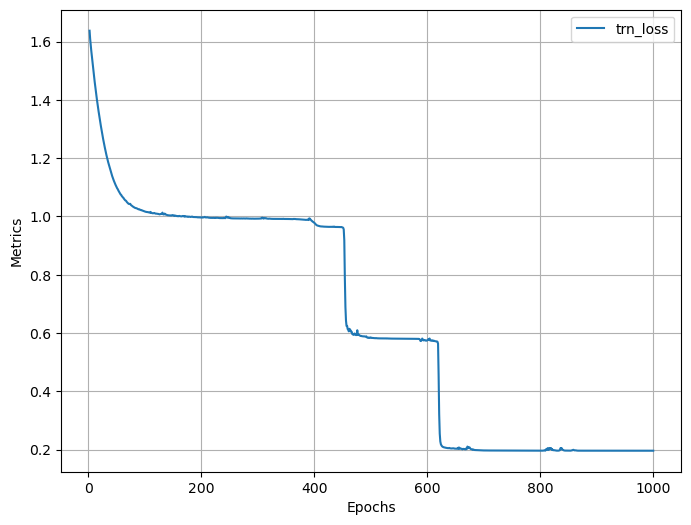

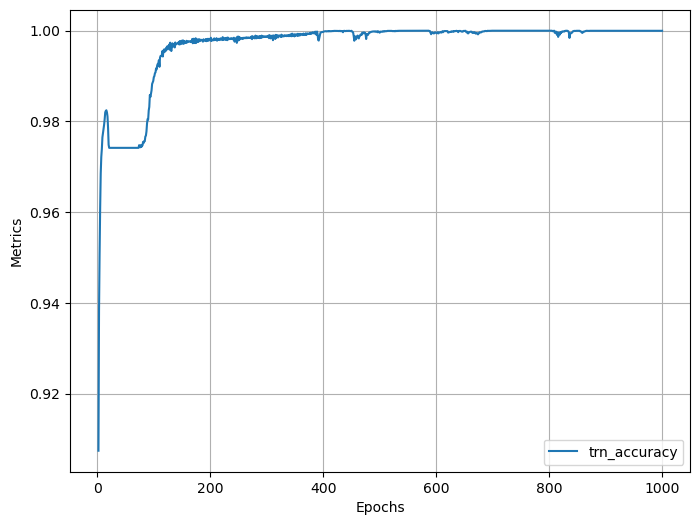

In [24]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images[:n_reduced_data],
    labels=train_labels[:n_reduced_data],
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_reduced_data_frozen_encoder")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["dice_focal"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=True,
    use_lr_scheduler=False
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.849  trn_accuracy: 0.302  (0.31s - 306.14s remaining)
EPOCH: 2.000  trn_loss: 1.799  trn_accuracy: 0.505  (0.62s - 307.21s remaining)
EPOCH: 3.000  trn_loss: 1.756  trn_accuracy: 0.755  (0.97s - 323.89s remaining)
EPOCH: 4.000  trn_loss: 1.728  trn_accuracy: 0.822  (1.31s - 325.23s remaining)
EPOCH: 5.000  trn_loss: 1.707  trn_accuracy: 0.847  (1.61s - 320.84s remaining)
EPOCH: 6.000  trn_loss: 1.688  trn_accuracy: 0.866  (1.92s - 318.17s remaining)
EPOCH: 7.000  trn_loss: 1.671  trn_accuracy: 0.878  (2.22s - 315.40s remaining)
EPOCH: 8.000  trn_loss: 1.658  trn_accuracy: 0.889  (2.53s - 313.38s remaining)
EPOCH: 9.000  trn_loss: 1.648  trn_accuracy: 0.902  (2.83s - 311.99s remaining)
EPOCH: 10.000  trn_loss: 1.637  trn_accuracy: 0.916  (3.14s - 310.44s remaining)
EPOCH: 11.000  trn_loss: 1.625  trn_accuracy: 0.927  (3.44s - 309.21s remainin

100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


EPOCH: 201.000  trn_loss: 0.974  trn_accuracy: 0.999  (67.21s - 267.15s remaining)
EPOCH: 202.000  trn_loss: 0.973  trn_accuracy: 0.999  (67.51s - 266.71s remaining)
EPOCH: 203.000  trn_loss: 0.972  trn_accuracy: 1.000  (67.82s - 266.26s remaining)
EPOCH: 204.000  trn_loss: 0.972  trn_accuracy: 1.000  (68.12s - 265.81s remaining)
EPOCH: 205.000  trn_loss: 0.972  trn_accuracy: 1.000  (68.44s - 265.41s remaining)
EPOCH: 206.000  trn_loss: 0.971  trn_accuracy: 1.000  (68.74s - 264.96s remaining)
EPOCH: 207.000  trn_loss: 0.971  trn_accuracy: 1.000  (69.05s - 264.51s remaining)
EPOCH: 208.000  trn_loss: 0.971  trn_accuracy: 1.000  (69.36s - 264.08s remaining)
EPOCH: 209.000  trn_loss: 0.971  trn_accuracy: 1.000  (69.66s - 263.65s remaining)
EPOCH: 210.000  trn_loss: 0.971  trn_accuracy: 1.000  (69.97s - 263.22s remaining)
EPOCH: 211.000  trn_loss: 0.971  trn_accuracy: 1.000  (70.28s - 262.78s remaining)
EPOCH: 212.000  trn_loss: 0.972  trn_accuracy: 1.000  (70.58s - 262.34s remaining)
EPOC

100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


EPOCH: 401.000  trn_loss: 0.965  trn_accuracy: 1.000  (132.65s - 198.15s remaining)
EPOCH: 402.000  trn_loss: 0.965  trn_accuracy: 1.000  (132.97s - 197.81s remaining)
EPOCH: 403.000  trn_loss: 0.965  trn_accuracy: 1.000  (133.27s - 197.43s remaining)
EPOCH: 404.000  trn_loss: 0.966  trn_accuracy: 1.000  (133.58s - 197.06s remaining)
EPOCH: 405.000  trn_loss: 0.965  trn_accuracy: 1.000  (133.90s - 196.72s remaining)
EPOCH: 406.000  trn_loss: 0.964  trn_accuracy: 1.000  (134.23s - 196.39s remaining)
EPOCH: 407.000  trn_loss: 0.964  trn_accuracy: 1.000  (134.57s - 196.06s remaining)
EPOCH: 408.000  trn_loss: 0.964  trn_accuracy: 1.000  (134.90s - 195.74s remaining)
EPOCH: 409.000  trn_loss: 0.964  trn_accuracy: 1.000  (135.24s - 195.41s remaining)
EPOCH: 410.000  trn_loss: 0.964  trn_accuracy: 1.000  (135.57s - 195.09s remaining)
EPOCH: 411.000  trn_loss: 0.964  trn_accuracy: 1.000  (135.91s - 194.76s remaining)
EPOCH: 412.000  trn_loss: 0.964  trn_accuracy: 1.000  (136.24s - 194.44s rem

100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


EPOCH: 601.000  trn_loss: 0.314  trn_accuracy: 0.999  (198.48s - 131.77s remaining)
EPOCH: 602.000  trn_loss: 0.255  trn_accuracy: 1.000  (198.89s - 131.49s remaining)
EPOCH: 603.000  trn_loss: 0.239  trn_accuracy: 0.999  (199.21s - 131.16s remaining)
EPOCH: 604.000  trn_loss: 0.220  trn_accuracy: 1.000  (199.52s - 130.81s remaining)
EPOCH: 605.000  trn_loss: 0.220  trn_accuracy: 1.000  (199.83s - 130.47s remaining)
EPOCH: 606.000  trn_loss: 0.215  trn_accuracy: 0.999  (200.14s - 130.12s remaining)
EPOCH: 607.000  trn_loss: 0.216  trn_accuracy: 0.999  (200.44s - 129.77s remaining)
EPOCH: 608.000  trn_loss: 0.213  trn_accuracy: 0.999  (200.75s - 129.43s remaining)
EPOCH: 609.000  trn_loss: 0.212  trn_accuracy: 1.000  (201.05s - 129.08s remaining)
EPOCH: 610.000  trn_loss: 0.212  trn_accuracy: 0.999  (201.36s - 128.74s remaining)
EPOCH: 611.000  trn_loss: 0.209  trn_accuracy: 1.000  (201.66s - 128.39s remaining)
EPOCH: 612.000  trn_loss: 0.205  trn_accuracy: 1.000  (201.97s - 128.05s rem

100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


EPOCH: 801.000  trn_loss: 0.196  trn_accuracy: 1.000  (265.39s - 65.93s remaining)
EPOCH: 802.000  trn_loss: 0.196  trn_accuracy: 1.000  (265.70s - 65.60s remaining)
EPOCH: 803.000  trn_loss: 0.196  trn_accuracy: 1.000  (266.00s - 65.26s remaining)
EPOCH: 804.000  trn_loss: 0.196  trn_accuracy: 1.000  (266.30s - 64.92s remaining)
EPOCH: 805.000  trn_loss: 0.196  trn_accuracy: 1.000  (266.61s - 64.58s remaining)
EPOCH: 806.000  trn_loss: 0.196  trn_accuracy: 1.000  (266.91s - 64.24s remaining)
EPOCH: 807.000  trn_loss: 0.196  trn_accuracy: 1.000  (267.21s - 63.91s remaining)
EPOCH: 808.000  trn_loss: 0.196  trn_accuracy: 1.000  (267.51s - 63.57s remaining)
EPOCH: 809.000  trn_loss: 0.196  trn_accuracy: 1.000  (267.82s - 63.23s remaining)
EPOCH: 810.000  trn_loss: 0.196  trn_accuracy: 1.000  (268.12s - 62.89s remaining)
EPOCH: 811.000  trn_loss: 0.196  trn_accuracy: 1.000  (268.42s - 62.55s remaining)
EPOCH: 812.000  trn_loss: 0.196  trn_accuracy: 1.000  (268.72s - 62.22s remaining)
EPOC

100%|██████████| 1101/1101 [00:00<00:00, 13932.17it/s]


[INFO] Training Metrics


7it [00:00, 24.04it/s]


[INFO] Avg Accuracy: 0.9999033212661743 +/- 9.592697460902855e-05
[INFO] Avg Dice: 0.9981290839392745 +/- 0.0019012924943134436
[INFO] Test Metrics


20it [00:00, 22.88it/s]


[INFO] Avg Accuracy: 0.98249751329422 +/- 0.008874473161995411
[INFO] Avg Dice: 0.35876982306514044 +/- 0.37020176247859


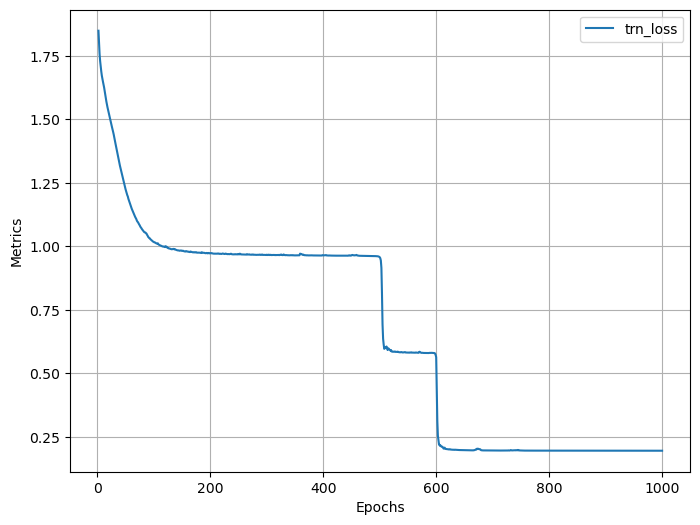

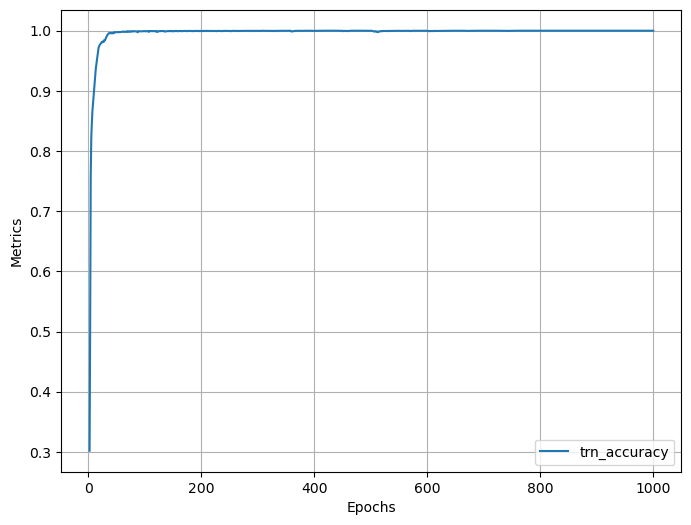

In [25]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images[:n_reduced_data],
    labels=train_labels[:n_reduced_data],
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_reduced_data_fixed_lr")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["dice_focal"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=False
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.769  trn_accuracy: 0.494  (0.34s - 337.90s remaining)
EPOCH: 2.000  trn_loss: 1.769  trn_accuracy: 0.495  (0.68s - 338.86s remaining)
EPOCH: 3.000  trn_loss: 1.768  trn_accuracy: 0.496  (1.02s - 338.70s remaining)
EPOCH: 4.000  trn_loss: 1.768  trn_accuracy: 0.498  (1.36s - 339.20s remaining)
EPOCH: 5.000  trn_loss: 1.768  trn_accuracy: 0.501  (1.73s - 344.82s remaining)
EPOCH: 6.000  trn_loss: 1.768  trn_accuracy: 0.503  (2.08s - 345.10s remaining)
EPOCH: 7.000  trn_loss: 1.767  trn_accuracy: 0.506  (2.42s - 343.41s remaining)
EPOCH: 8.000  trn_loss: 1.767  trn_accuracy: 0.509  (2.76s - 341.84s remaining)
EPOCH: 9.000  trn_loss: 1.766  trn_accuracy: 0.513  (3.09s - 340.65s remaining)
EPOCH: 10.000  trn_loss: 1.765  trn_accuracy: 0.517  (3.43s - 339.60s remaining)
EPOCH: 11.000  trn_loss: 1.765  trn_accuracy: 0.523  (3.77s - 338.64s remainin

100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


EPOCH: 201.000  trn_loss: 1.096  trn_accuracy: 0.998  (65.96s - 262.18s remaining)
EPOCH: 202.000  trn_loss: 1.094  trn_accuracy: 0.999  (66.31s - 261.97s remaining)
EPOCH: 203.000  trn_loss: 1.095  trn_accuracy: 0.997  (66.63s - 261.58s remaining)
EPOCH: 204.000  trn_loss: 1.089  trn_accuracy: 0.999  (66.94s - 261.19s remaining)
EPOCH: 205.000  trn_loss: 1.086  trn_accuracy: 0.999  (67.25s - 260.80s remaining)
EPOCH: 206.000  trn_loss: 1.085  trn_accuracy: 0.999  (67.60s - 260.55s remaining)
EPOCH: 207.000  trn_loss: 1.081  trn_accuracy: 0.999  (67.95s - 260.29s remaining)
EPOCH: 208.000  trn_loss: 1.080  trn_accuracy: 0.999  (68.25s - 259.87s remaining)
EPOCH: 209.000  trn_loss: 1.079  trn_accuracy: 0.998  (68.61s - 259.67s remaining)
EPOCH: 210.000  trn_loss: 1.076  trn_accuracy: 0.999  (68.95s - 259.39s remaining)
EPOCH: 211.000  trn_loss: 1.074  trn_accuracy: 0.999  (69.29s - 259.10s remaining)
EPOCH: 212.000  trn_loss: 1.072  trn_accuracy: 0.999  (69.64s - 258.85s remaining)
EPOC

100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


EPOCH: 401.000  trn_loss: 0.976  trn_accuracy: 0.998  (131.64s - 196.64s remaining)
EPOCH: 402.000  trn_loss: 0.972  trn_accuracy: 1.000  (131.98s - 196.32s remaining)
EPOCH: 403.000  trn_loss: 0.971  trn_accuracy: 1.000  (132.31s - 196.00s remaining)
EPOCH: 404.000  trn_loss: 0.971  trn_accuracy: 1.000  (132.65s - 195.69s remaining)
EPOCH: 405.000  trn_loss: 0.971  trn_accuracy: 1.000  (133.01s - 195.41s remaining)
EPOCH: 406.000  trn_loss: 0.971  trn_accuracy: 1.000  (133.32s - 195.05s remaining)
EPOCH: 407.000  trn_loss: 0.970  trn_accuracy: 1.000  (133.63s - 194.69s remaining)
EPOCH: 408.000  trn_loss: 0.970  trn_accuracy: 1.000  (133.93s - 194.34s remaining)
EPOCH: 409.000  trn_loss: 0.971  trn_accuracy: 1.000  (134.24s - 193.98s remaining)
EPOCH: 410.000  trn_loss: 0.971  trn_accuracy: 1.000  (134.55s - 193.62s remaining)
EPOCH: 411.000  trn_loss: 0.970  trn_accuracy: 1.000  (134.86s - 193.27s remaining)
EPOCH: 412.000  trn_loss: 0.970  trn_accuracy: 1.000  (135.17s - 192.91s rem

100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


EPOCH: 601.000  trn_loss: 0.964  trn_accuracy: 1.000  (199.27s - 132.30s remaining)
EPOCH: 602.000  trn_loss: 0.964  trn_accuracy: 1.000  (199.62s - 131.98s remaining)
EPOCH: 603.000  trn_loss: 0.964  trn_accuracy: 1.000  (199.96s - 131.65s remaining)
EPOCH: 604.000  trn_loss: 0.964  trn_accuracy: 1.000  (200.29s - 131.32s remaining)
EPOCH: 605.000  trn_loss: 0.964  trn_accuracy: 1.000  (200.62s - 130.99s remaining)
EPOCH: 606.000  trn_loss: 0.964  trn_accuracy: 1.000  (200.95s - 130.65s remaining)
EPOCH: 607.000  trn_loss: 0.964  trn_accuracy: 1.000  (201.29s - 130.32s remaining)
EPOCH: 608.000  trn_loss: 0.964  trn_accuracy: 1.000  (201.62s - 129.99s remaining)
EPOCH: 609.000  trn_loss: 0.964  trn_accuracy: 1.000  (201.95s - 129.66s remaining)
EPOCH: 610.000  trn_loss: 0.964  trn_accuracy: 1.000  (202.28s - 129.33s remaining)
EPOCH: 611.000  trn_loss: 0.964  trn_accuracy: 1.000  (202.62s - 129.00s remaining)
EPOCH: 612.000  trn_loss: 0.964  trn_accuracy: 1.000  (202.94s - 128.66s rem

100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


EPOCH: 801.000  trn_loss: 0.622  trn_accuracy: 0.997  (266.00s - 66.08s remaining)
EPOCH: 802.000  trn_loss: 0.616  trn_accuracy: 0.998  (266.30s - 65.74s remaining)
EPOCH: 803.000  trn_loss: 0.606  trn_accuracy: 0.998  (266.60s - 65.40s remaining)
EPOCH: 804.000  trn_loss: 0.598  trn_accuracy: 0.999  (266.89s - 65.06s remaining)
EPOCH: 805.000  trn_loss: 0.596  trn_accuracy: 0.999  (267.19s - 64.72s remaining)
EPOCH: 806.000  trn_loss: 0.595  trn_accuracy: 0.999  (267.49s - 64.38s remaining)
EPOCH: 807.000  trn_loss: 0.593  trn_accuracy: 0.999  (267.79s - 64.04s remaining)
EPOCH: 808.000  trn_loss: 0.594  trn_accuracy: 0.999  (268.09s - 63.70s remaining)
EPOCH: 809.000  trn_loss: 0.592  trn_accuracy: 0.999  (268.39s - 63.36s remaining)
EPOCH: 810.000  trn_loss: 0.590  trn_accuracy: 0.999  (268.69s - 63.03s remaining)
EPOCH: 811.000  trn_loss: 0.590  trn_accuracy: 0.999  (268.99s - 62.69s remaining)
EPOCH: 812.000  trn_loss: 0.589  trn_accuracy: 1.000  (269.29s - 62.35s remaining)
EPOC

100%|██████████| 1101/1101 [00:00<00:00, 12964.06it/s]


[INFO] Training Metrics


7it [00:00, 24.14it/s]


[INFO] Avg Accuracy: 0.9999380111694336 +/- 6.936799036338925e-05
[INFO] Avg Dice: 0.9988238099427432 +/- 0.001356725498478338
[INFO] Test Metrics


20it [00:00, 23.79it/s]

[INFO] Avg Accuracy: 0.9830764532089233 +/- 0.007334898225963116
[INFO] Avg Dice: 0.3324288271858924 +/- 0.3437129837152022


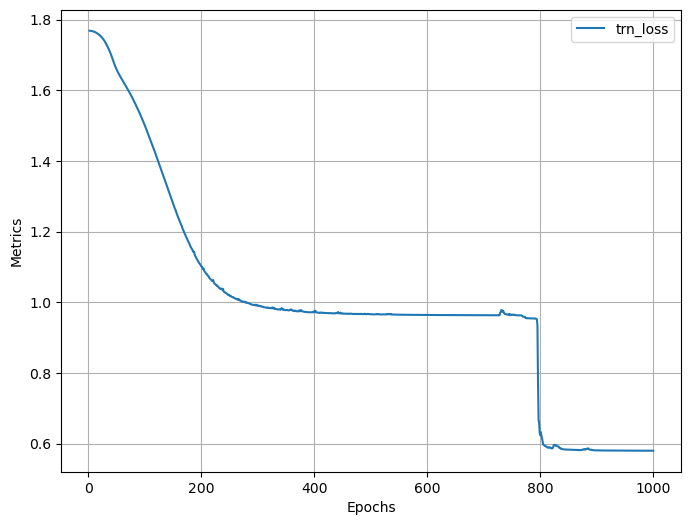

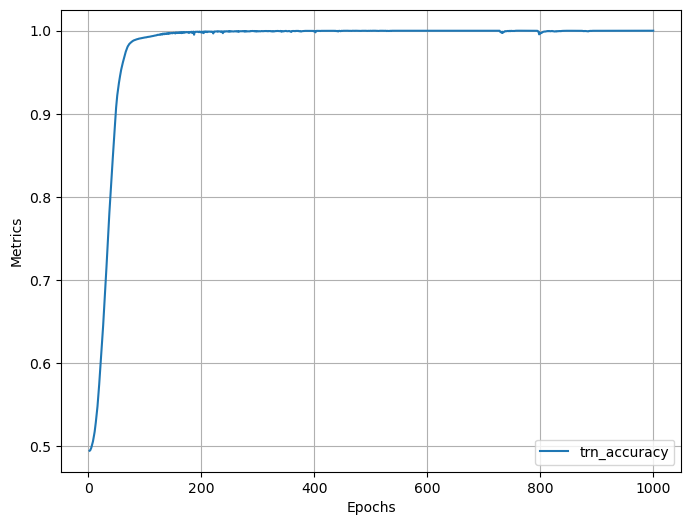

In [26]:
# Training with image ID 0 only
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images[:n_reduced_data],
    labels=train_labels[:n_reduced_data],
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[8, 8, 8],
    kernel_sizes=[3, 3, 3],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_reduced_data_lr_scheduler")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[3, 8, 8, 8] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=1000,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["dice_focal"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=True
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)